# Importation des bibliothèques nécessaires

In [104]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn import metrics, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
import plotly_express as px
from plotly.offline import iplot
import plotly.io as pio
from statsmodels.tsa.seasonal import STL
pio.renderers.default='notebook'

# Ouverture des fichiers

In [105]:
#Ouverture des données issues de era 5
chemin_fichier_nc = 'era 5/wave 2016.nc'

ds = xr.open_dataset(chemin_fichier_nc)
wave_era5 = ds.to_dataframe()
wave_era5 = wave_era5.reset_index()
wave_era5 = wave_era5[(wave_era5['latitude'] == -17)&(wave_era5['longitude'] == -150)]
wave_era5 = wave_era5.rename(columns={'time': 'DateTime'})
wave_era5 = wave_era5.groupby(pd.Grouper(key='DateTime', freq='1D')).mean().reset_index()
wave_era5 = wave_era5[['DateTime','mwp','shts','shww','hmax','mpts','mpww','pp1d','swh','tmax']]
wave_era5 = wave_era5.reset_index().drop(columns='index')

wave_2016_era5 = wave_era5[(wave_era5['DateTime'] >= pd.to_datetime('2016-07-28'))&(wave_era5['DateTime'] <= pd.to_datetime('2016-11-25'))] #pour comparer aux valeurs de 2016



chemin_fichier_nc = 'era 5/paroa 2016.nc'
ds = xr.open_dataset(chemin_fichier_nc)
wave_era5 = ds.to_dataframe()
wave_era5 = wave_era5.reset_index()
wave_era5 = wave_era5[(wave_era5['latitude'] == -17)&(wave_era5['longitude'] == -150)]
wave_era5 = wave_era5.rename(columns={'time': 'DateTime'})
wave_era5 = wave_era5.groupby(pd.Grouper(key='DateTime', freq='1D')).mean().reset_index()
wave_era5 = wave_era5[['DateTime','swh','mpts']]
wave_era5 = wave_era5.reset_index().drop(columns='index')

for i in range(1991,2024):
    if i !=2016 : #car déjà traité à part
        chemin_fichier_nc = 'era 5/parao'+str(i)+'.nc'
        ds = xr.open_dataset(chemin_fichier_nc)
        wave_era5_n = ds.to_dataframe()
        wave_era5_n = wave_era5_n.reset_index()
        wave_era5_n = wave_era5_n[(wave_era5_n['latitude'] == -17)&(wave_era5_n['longitude'] == -150)]
        wave_era5_n = wave_era5_n.rename(columns={'time': 'DateTime'})
        wave_era5_n = wave_era5_n.groupby(pd.Grouper(key='DateTime', freq='1D')).mean().reset_index()
        wave_era5_n = wave_era5_n[['DateTime','swh','mpts']]
        wave_era5_n = wave_era5_n.reset_index().drop(columns='index')
        wave_era5 = pd.concat([wave_era5,wave_era5_n])
       

wave_era5.reset_index(inplace=True)

wave_era5=wave_era5.sort_values(by='DateTime')
#Ouverture des données issues des houlographes
nouv_houle = pd.read_csv('relevé houlographe/SondeSBE26MooreaPointeSud_ViewProcessedWaves.csv',sep= ';')
nouv_houle['DateTime'] = nouv_houle['Date'].astype('datetime64[ns]')
nouv_houle['DateTime'] = nouv_houle['DateTime']+pd.DateOffset(hours=10) #car les dates des houlographes sont en UTC-10
nouv_houle['Significant height (cm)'] = nouv_houle['Significant height (cm)']*(10**(-2))
nouv_houle = nouv_houle.rename(columns={'Significant height (cm)': 'Hauteur'})
nouv_houle = nouv_houle.rename(columns={'Significant period (sec)': 'Période'})
nouv_houle=nouv_houle[['DateTime','Hauteur','Période']]
nouv_houle['DateTime']=nouv_houle['DateTime'].dt.date.astype('datetime64[ns]')
nouv_houle= nouv_houle.groupby(pd.Grouper(key='DateTime', freq='1D')).mean().reset_index()
nouv_houle_2016 = nouv_houle #pour comparer aux valeurs de 2016

nouv_houle_2 = pd.read_csv('relevé houlographe/OSSIMooreaPointeSud_View.csv',sep= ';')
nouv_houle_2['DateTime'] = nouv_houle_2['Date'].astype('datetime64[ns]')
nouv_houle_2['DateTime'] = nouv_houle_2['DateTime']+pd.DateOffset(hours=10) #car les dates des houlographes sont en UTC-10
nouv_houle_2 = nouv_houle_2.rename(columns={'Hs (m)': 'Hauteur'})
nouv_houle_2 = nouv_houle_2.rename(columns={'Tpeak (s)': 'Période'})
nouv_houle_2=nouv_houle_2[['DateTime','Hauteur','Période']]
nouv_houle_2['DateTime']=nouv_houle_2['DateTime'].dt.date.astype('datetime64[ns]')
nouv_houle_2 = nouv_houle_2.groupby('DateTime').agg('mean').reset_index()
nouv_houle_2= pd.concat([nouv_houle_2,nouv_houle])

for i in range(6,13):
    if i != 11 : #un relevé est manquant
        nouv_houle_3 = pd.read_csv('relevé houlographe/Paroa0'+str(i)+'.csv',sep= ',')
        nouv_houle_3['DateTime'] =pd.to_datetime(dict(year=nouv_houle_3.Annee, month =nouv_houle_3.Mois, day=nouv_houle_3.Jour, hour=nouv_houle_3.Heure,minute=nouv_houle_3.Minute))
        nouv_houle_3['DateTime'] = nouv_houle_3['DateTime'].astype('datetime64[ns]')
        nouv_houle_3['DateTime'] = nouv_houle_3['DateTime']+pd.DateOffset(hours=10) #car les dates des houlographes sont en UTC-10
        nouv_houle_3 = nouv_houle_3.rename(columns={'Hs (m)': 'Hauteur'})
        nouv_houle_3 = nouv_houle_3.rename(columns={'Tpeak (s)': 'Période'})
        nouv_houle_3=nouv_houle_3[['DateTime','Hauteur','Période']]
        nouv_houle_3['DateTime']=nouv_houle_3['DateTime'].dt.date.astype('datetime64[ns]')
        nouv_houle_3 = nouv_houle_3.groupby('DateTime').agg('mean').reset_index()
        nouv_houle_2 = pd.concat([nouv_houle_3,nouv_houle_2])

nouv_houle_2.reset_index(inplace=True)
nouv_houle = nouv_houle_2

# Statistique descriptive

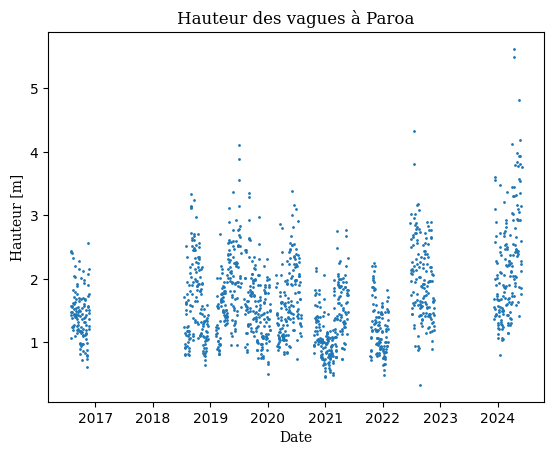

In [106]:
plt.scatter(nouv_houle_2['DateTime'], nouv_houle_2['Hauteur'], s = 1)
plt.xlabel('Date', fontfamily = 'serif')
plt.title('Hauteur des vagues à Paroa',fontfamily = 'serif')
plt.ylabel('Hauteur [m]', fontfamily = 'serif')
plt.savefig('output/statistique descriptive/Hauteur graphe')

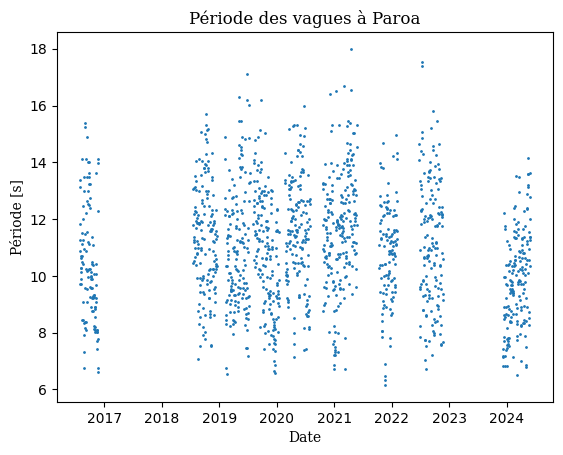

In [107]:
plt.scatter(nouv_houle_2['DateTime'], nouv_houle_2['Période'], s = 1)
plt.xlabel('Date', fontfamily = 'serif')
plt.title('Période des vagues à Paroa',fontfamily = 'serif')
plt.ylabel('Période [s]', fontfamily = 'serif')
plt.savefig('output/statistique descriptive/Période graphe')

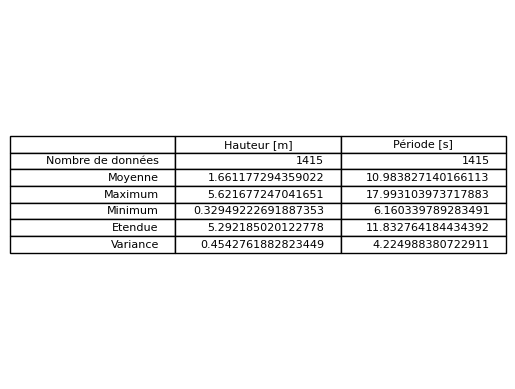

In [108]:
fig, ax = plt.subplots(1, 1)
data = [["Nombre de données",nouv_houle_2['Hauteur'].count(),nouv_houle_2['Hauteur'].count()],["Moyenne",nouv_houle_2['Hauteur'].mean(), nouv_houle_2['Période'].mean()], ["Maximum",nouv_houle_2['Hauteur'].max(), nouv_houle_2['Période'].max()], ["Minimum",nouv_houle_2['Hauteur'].min(), nouv_houle_2['Période'].min()],["Etendue",(nouv_houle_2['Hauteur'].max()-nouv_houle_2['Hauteur'].min()), (nouv_houle_2['Période'].max()-nouv_houle_2['Période'].min())],["Variance",np.var(nouv_houle_2['Hauteur']),np.var(nouv_houle_2['Période'])]]
column_labels = ["", "Hauteur [m]", "Période [s]"]
ax.axis("off")
ax.table(cellText=data, colLabels=column_labels, loc="center")
plt.savefig('output/statistique descriptive/Synthèse')

# Comparaison entre les deux jeux de données

In [109]:
def cross_correlation(data, column1, column2, lag_max): 
        ####  donne la corrélation entre deux colonnes, pour différentes valeurs de lag

    #### cette fonction prend les variables suivantes en entrée :
    # data = la dataframe
    # column1 = le nom de la première colonne à considérer
    # column2 = le nom de la deuxième colonne à considérer
    # lag_max = le déplacement maximal autorisé entre les deux séries temporelles 
    
    #### et en sortie :
    # cross_correlation,lags = la liste des corrélations trouvées accompagnée de la liste des écarts correspondants
    cross_correlation = []
    lags = []
    for lag in range(-lag_max,lag_max):
        cross_correlation.append(data[column1].shift(lag).corr(data[column2]))
        lags.append(lag)
    return np.array([cross_correlation, lags])

def find_lag(cross_cor):
        ####  détermine l'écart qui maximise la corrélation

    #### cette fonction prend la variable suivante en entrée :
    # cross_cor = numpy array contenant la liste des corrélations trouvées accompagnée de la liste des écarts correspondants
    
    #### et en sortie :
    # l'écart maximisant la corrélation
    max_cross_cor = max(np.abs(cross_cor[0]))
    index = np.where(np.abs(cross_cor[0]) == max_cross_cor)
    return int(cross_cor[1][index][0])

def find_best_cross_correlation(cross_cor):
        ####  détermine la valeur maximale de corrélation

    #### cette fonction prend la variable suivante en entrée :
    # cross_cor = numpy array contenant la liste des corrélations trouvées accompagnée de la liste des écarts correspondants
    
    #### et en sortie :
    # la corrélation maximale
    max_cross_cor = max(np.abs(cross_cor[0]))
    index = np.where(np.abs(cross_cor[0]) == max_cross_cor)
    return cross_cor[0][index][0]

def plot_with_best_lag(data, column1, column2, lag_max):
        ####  affiche la comparaison entre les deux séries temporelles lorsque la corrélation est maximisée

    #### cette fonction prend les variables suivantes en entrée :
    # data = la dataframe
    # column1 = le nom de la première colonne à considérer
    # column2 = le nom de la deuxième colonne à considérer
    # lag_max = le déplacement maximal autorisé entre les deux séries temporelles 
    
    #### et en sortie :
    # Trace la première série temporelle, avec la seconde, décalée de l'écart qui maximise la corrélation
    cross_cor = cross_correlation(data, column1, column2, lag_max)
    best_lag = find_lag(cross_cor)
    plt.figure(figsize=(10, 5))
    plt.plot(data['DateTime'], data[column2], label=column2)
    plt.plot(data['DateTime'], data[column1].shift(best_lag), label=column1)
    plt.legend()
    plt.xlabel('Date')
    plt.title('Best lag: ' + str((best_lag, data)) + ' with a cross-correlation of ' + str(np.round(max(cross_cor[0]), 2)))
    
def moving_average(data, window_size):
         ####  renvoie la moyenne glissante

    #### cette fonction prend les variables suivantes en entrée :
    # data = la série temporelle à laquelle on veut appliquer la fenêtre glissante
    # window_size = la taille de la fenêtre choisie
    
    #### et en sortie :
    # la moyenne glissance    
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

Lag for hmax is : 0


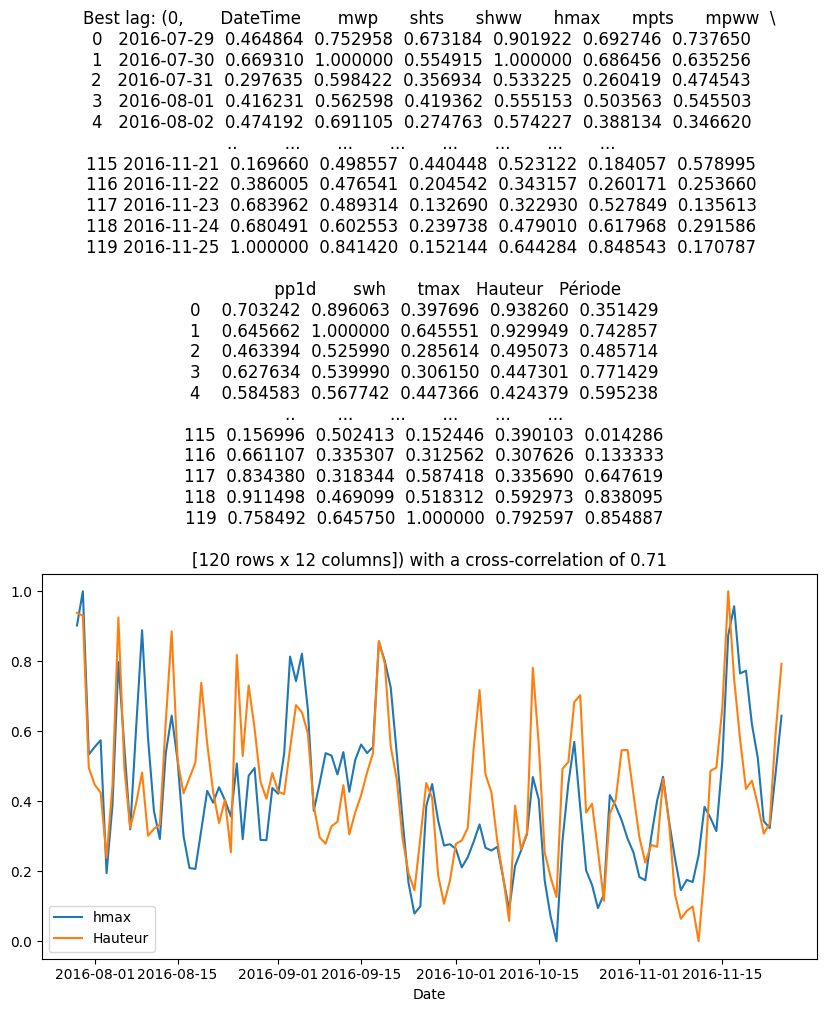

corrélation sans lag : 0.7146263361885359
rmse : 2.1339539544339754
corrélation avec lag : 0.7146263361885359
rmse : 2.1339539544339754


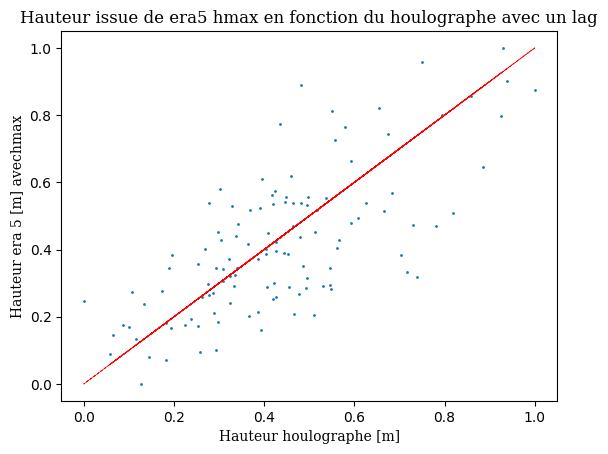

Lag for shts is : 0


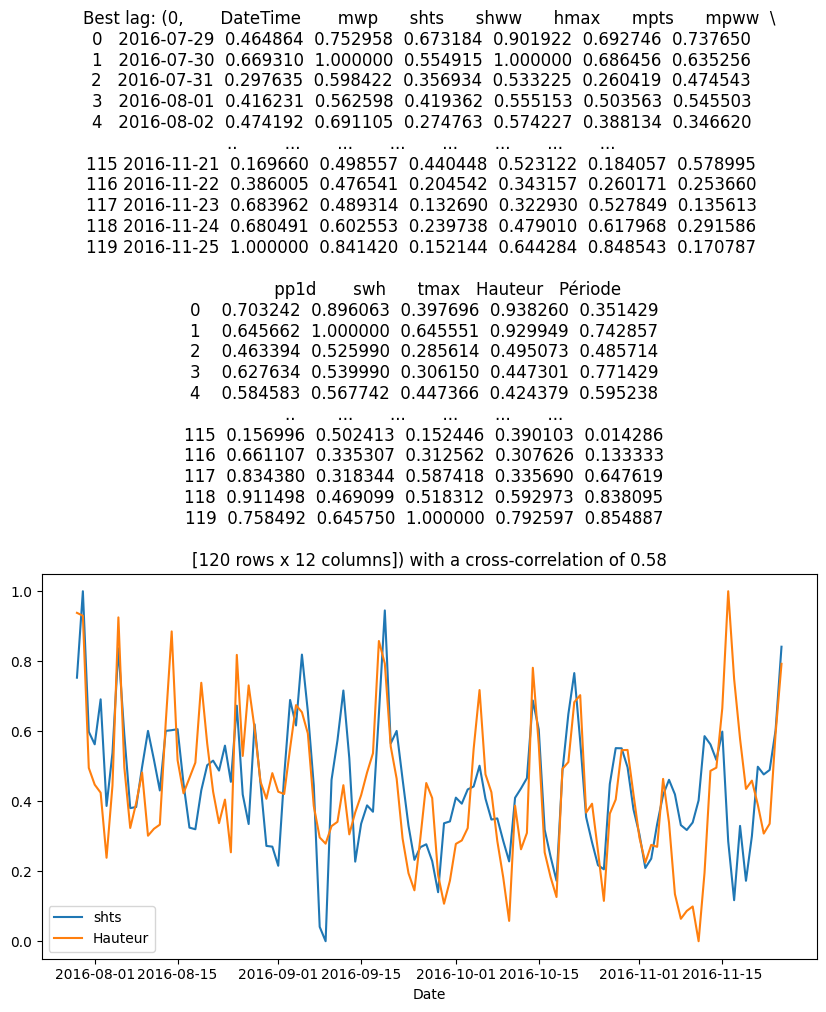

corrélation sans lag : 0.5843122707201069
rmse : 0.36219208328043956
corrélation avec lag : 0.5843122707201069
rmse : 0.36219208328043956


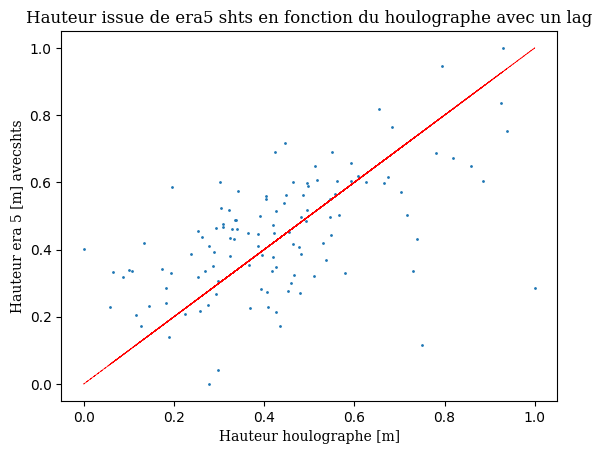

Lag for shww is : 0


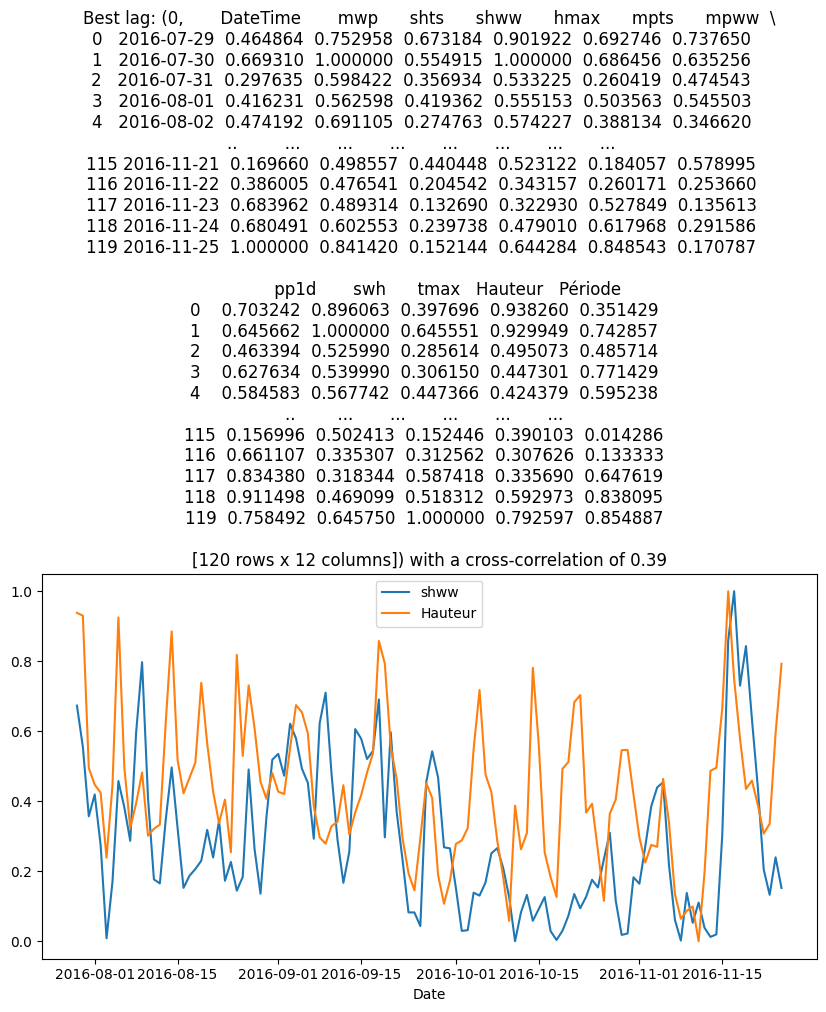

corrélation sans lag : 0.3879445360987464
rmse : 0.8774390784455649
corrélation avec lag : 0.3879445360987464
rmse : 0.8774390784455649


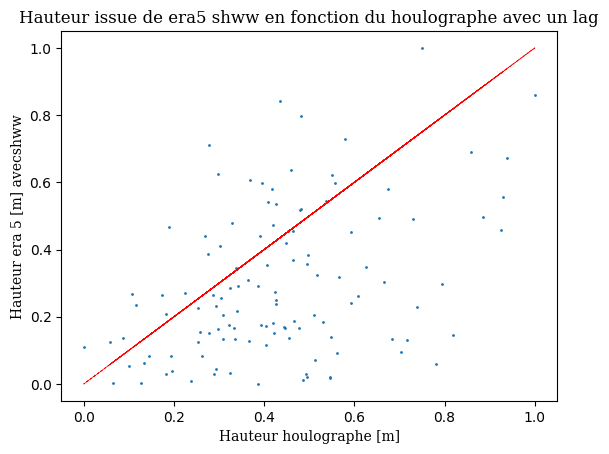

Lag for swh is : 0


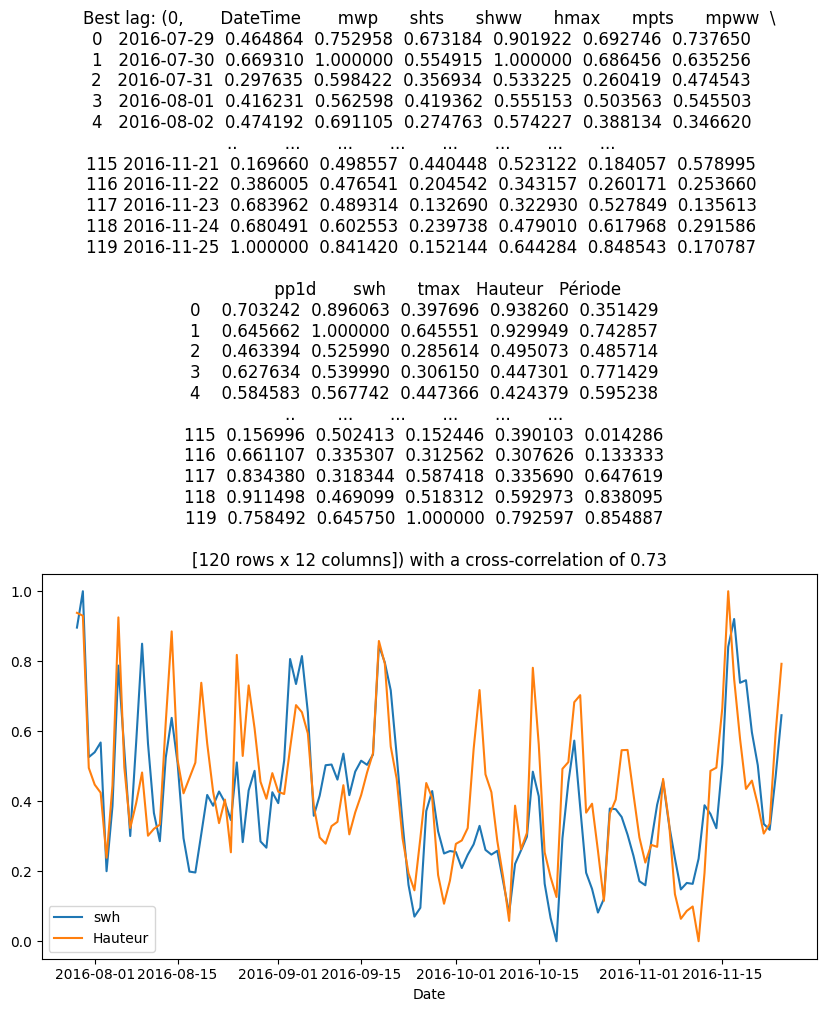

corrélation sans lag : 0.7294948739467848
rmse : 0.5000066046242836
corrélation avec lag : 0.7294948739467848
rmse : 0.5000066046242836


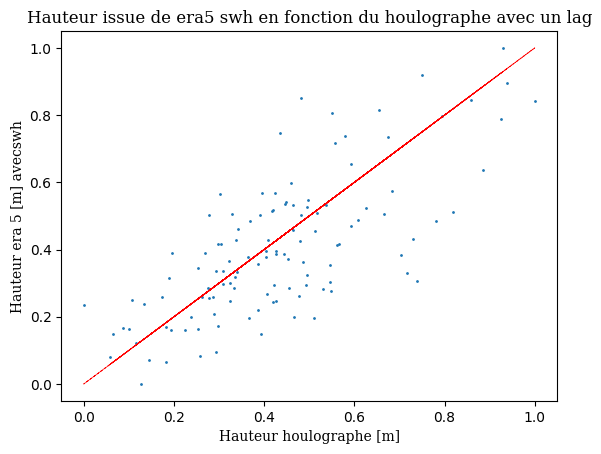

Lag for hmax is : 0


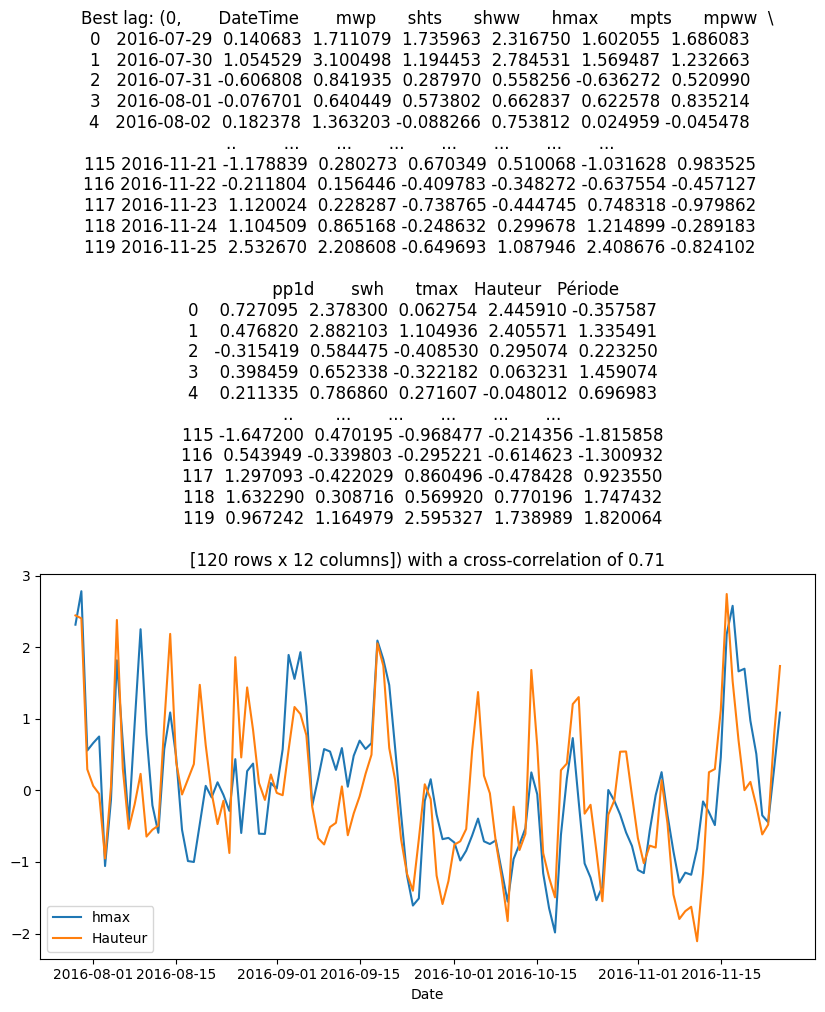

corrélation sans lag : 0.7146263361885359
rmse : 2.1339539544339754
corrélation avec lag : 0.7146263361885359
rmse : 2.1339539544339754


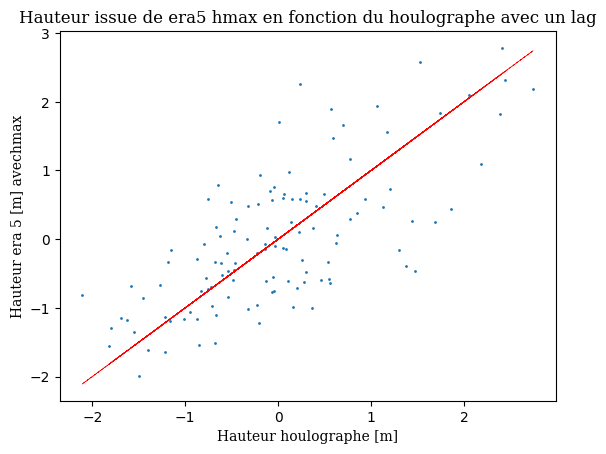

Lag for shts is : 0


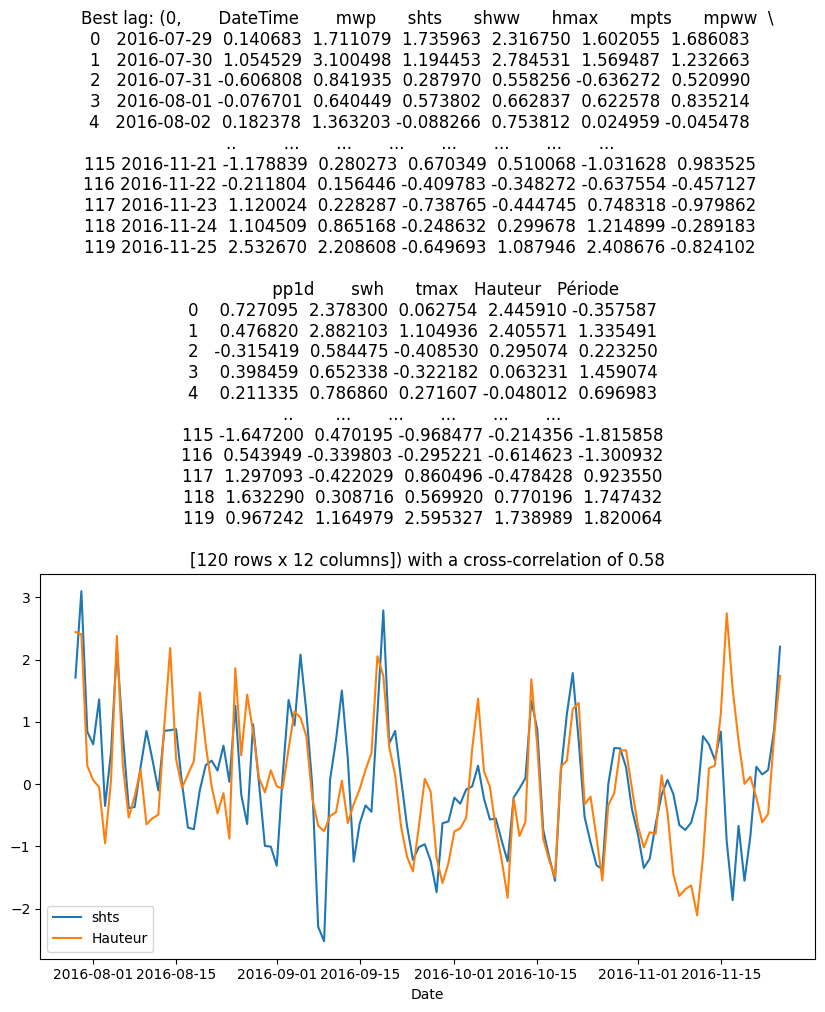

corrélation sans lag : 0.5843122707201069
rmse : 0.36219208328043956
corrélation avec lag : 0.5843122707201069
rmse : 0.36219208328043956


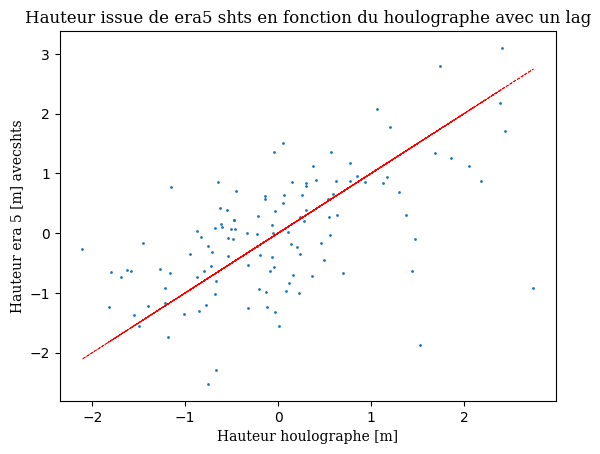

Lag for shww is : 0


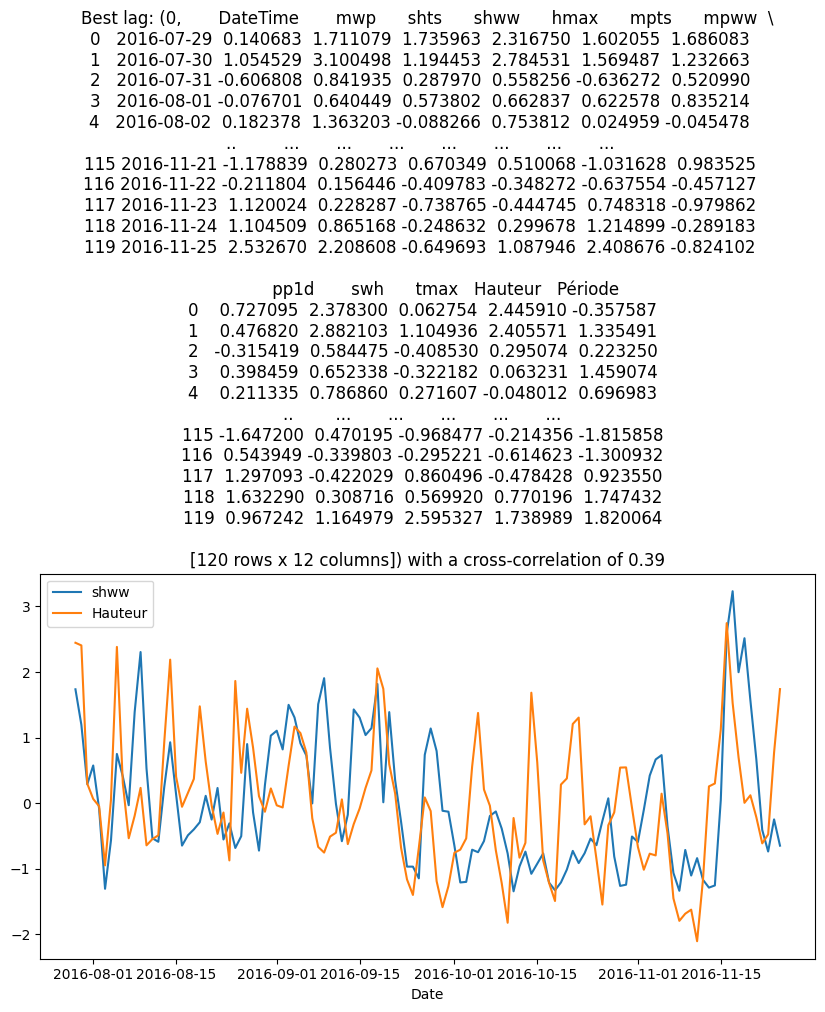

corrélation sans lag : 0.3879445360987464
rmse : 0.8774390784455649
corrélation avec lag : 0.3879445360987464
rmse : 0.8774390784455649


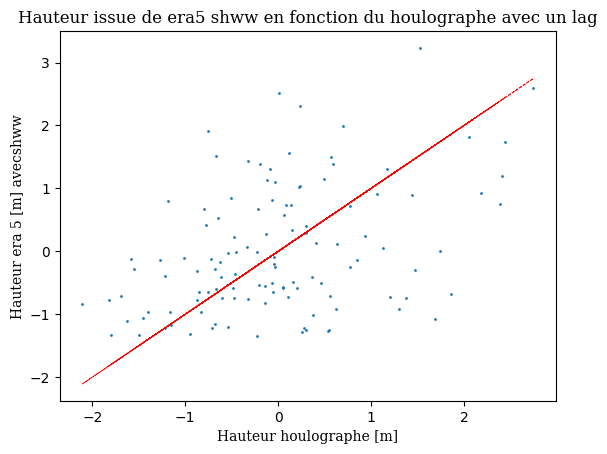

Lag for swh is : 0


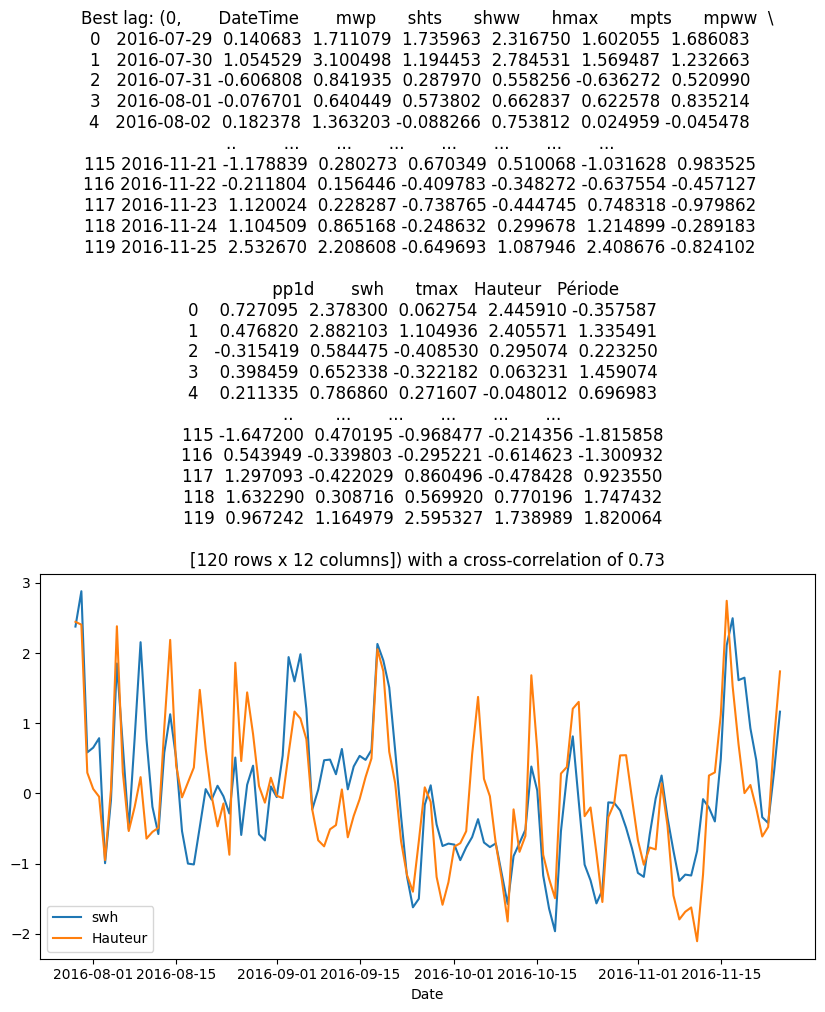

corrélation sans lag : 0.7294948739467848
rmse : 0.5000066046242836
corrélation avec lag : 0.7294948739467848
rmse : 0.5000066046242836


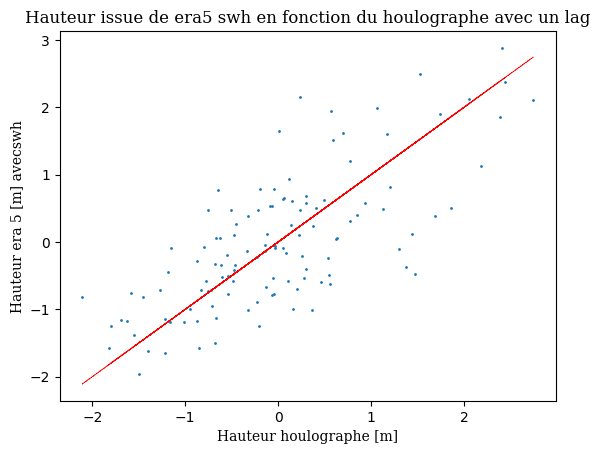

Lag for mpts is : 0


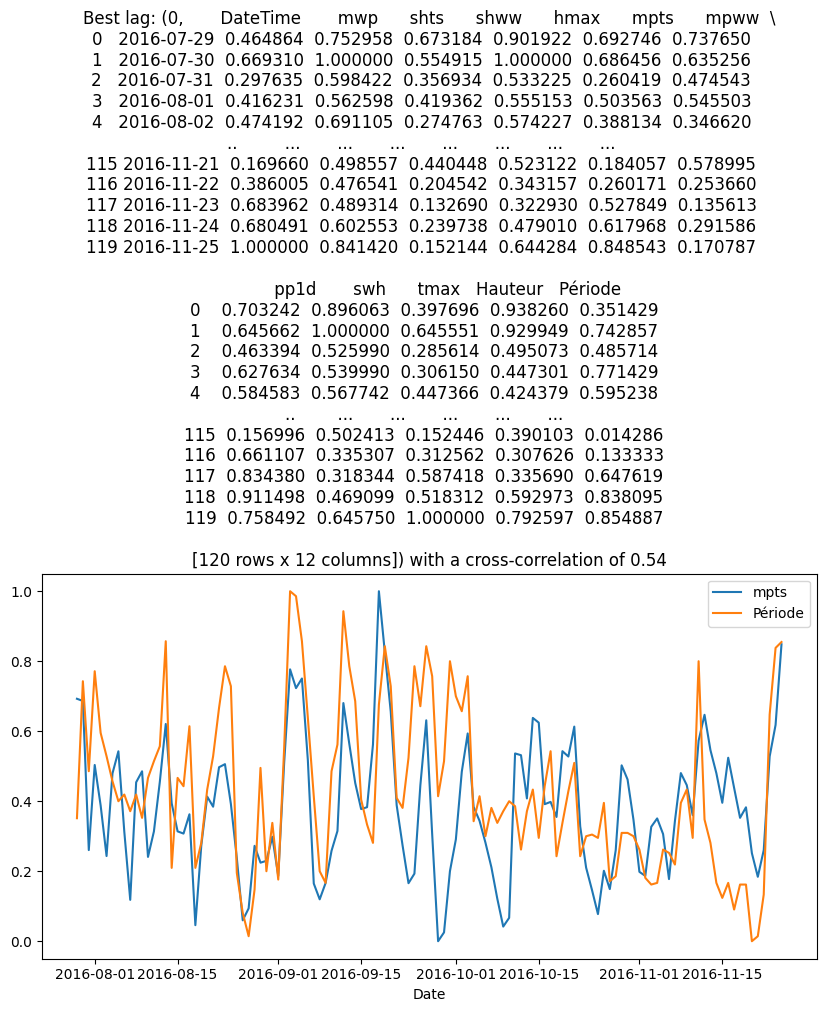

corrélation sans lag : 0.5359907594111619
rmse : 0.21322981593161283
corrélation avec lag : 0.5359907594111619
rmse : 1.8611090706982725


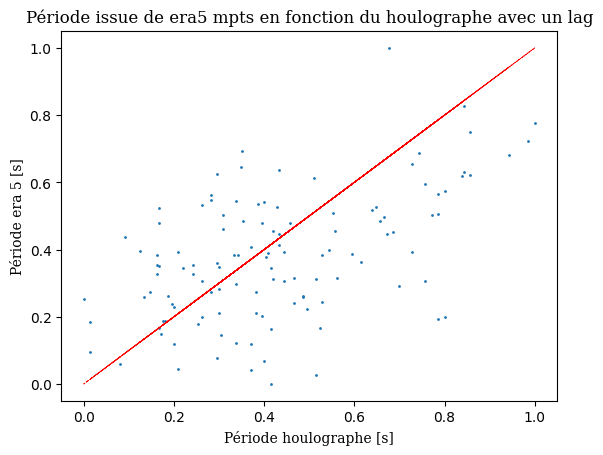

Lag for mpww is : -9


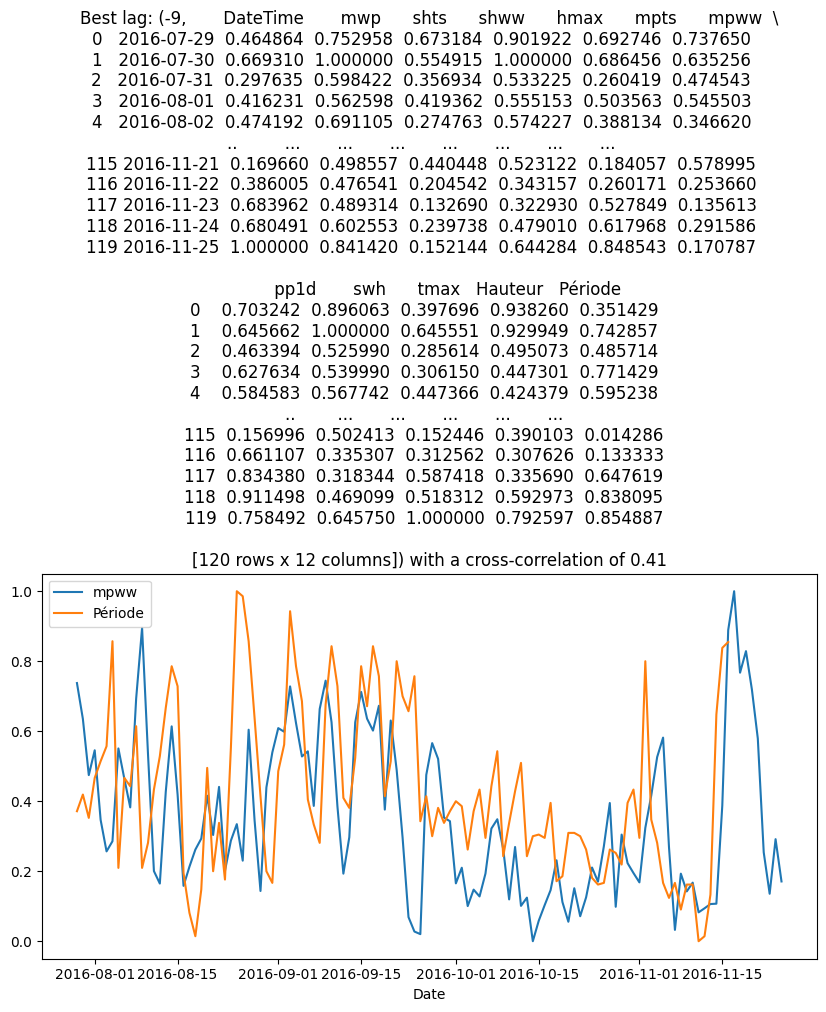

corrélation sans lag : -0.09700377849551574
rmse : 0.347185387721427
corrélation avec lag : 0.4060363193170436
rmse : 7.061268404041718


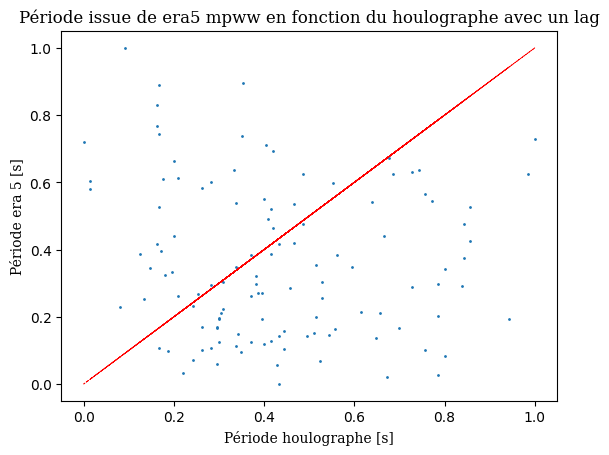

Lag for pp1d is : 0


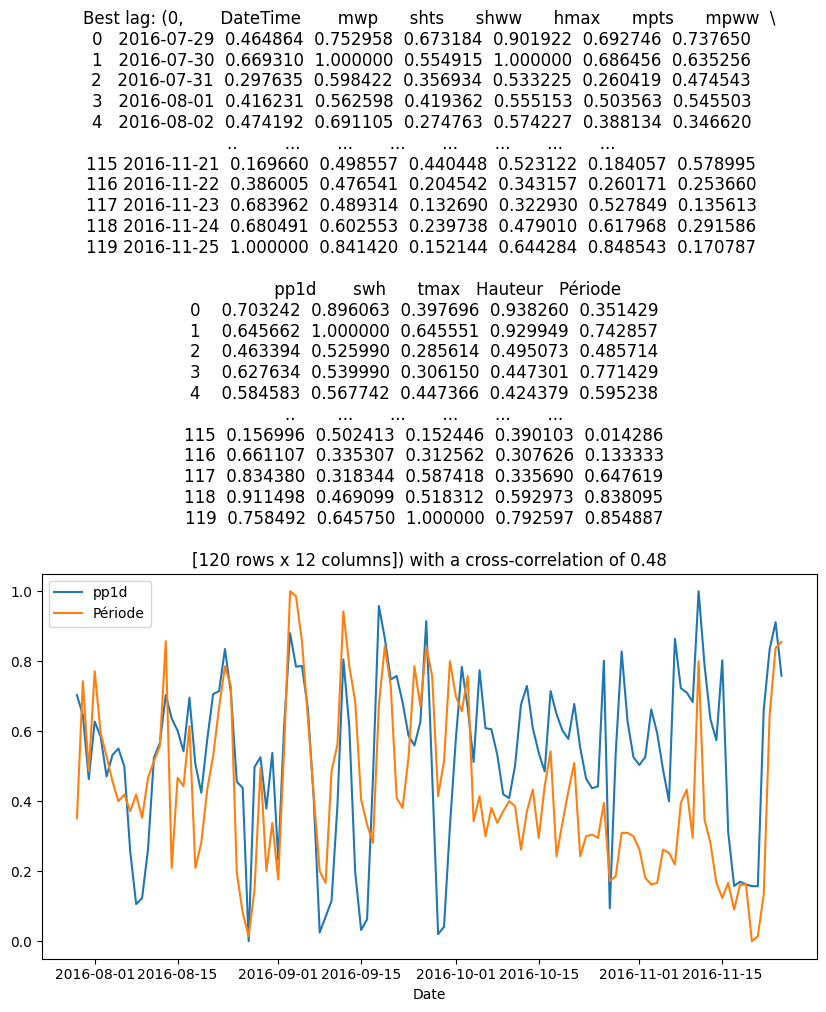

corrélation sans lag : 0.48315386624788736
rmse : 0.25565421839805974
corrélation avec lag : 0.48315386624788736
rmse : 2.9071085290480205


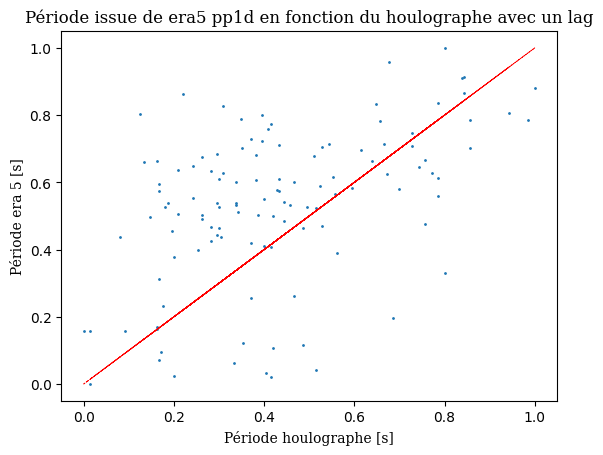

Lag for mwp is : 0


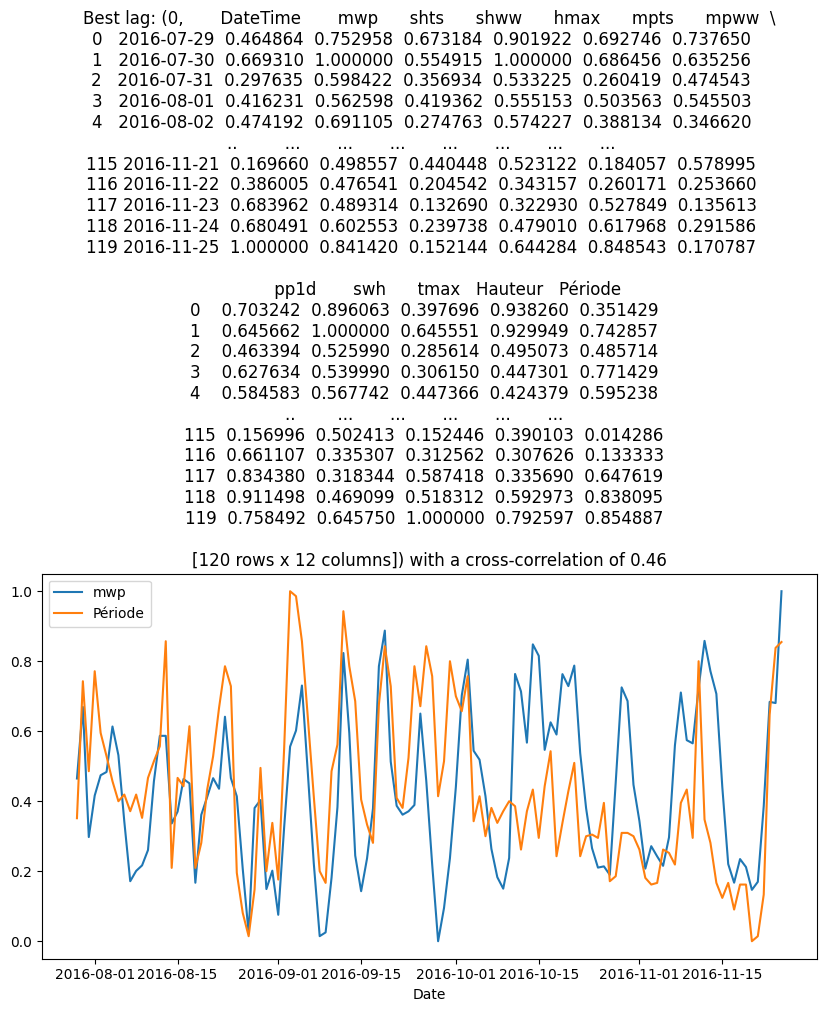

corrélation sans lag : 0.46228512242477726
rmse : 0.23596709266546928
corrélation avec lag : 0.46228512242477726
rmse : 2.4362040902132764


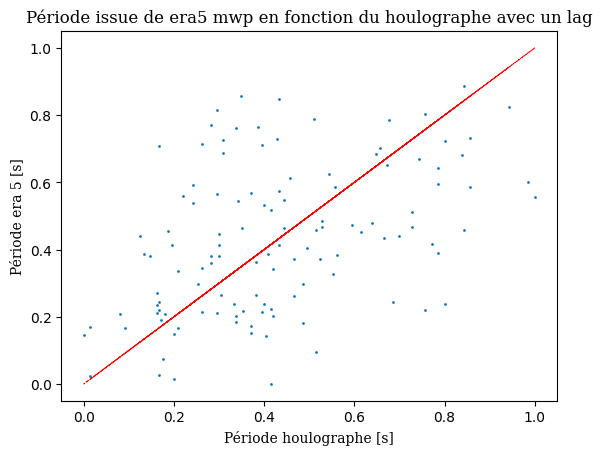

Lag for tmax is : -4


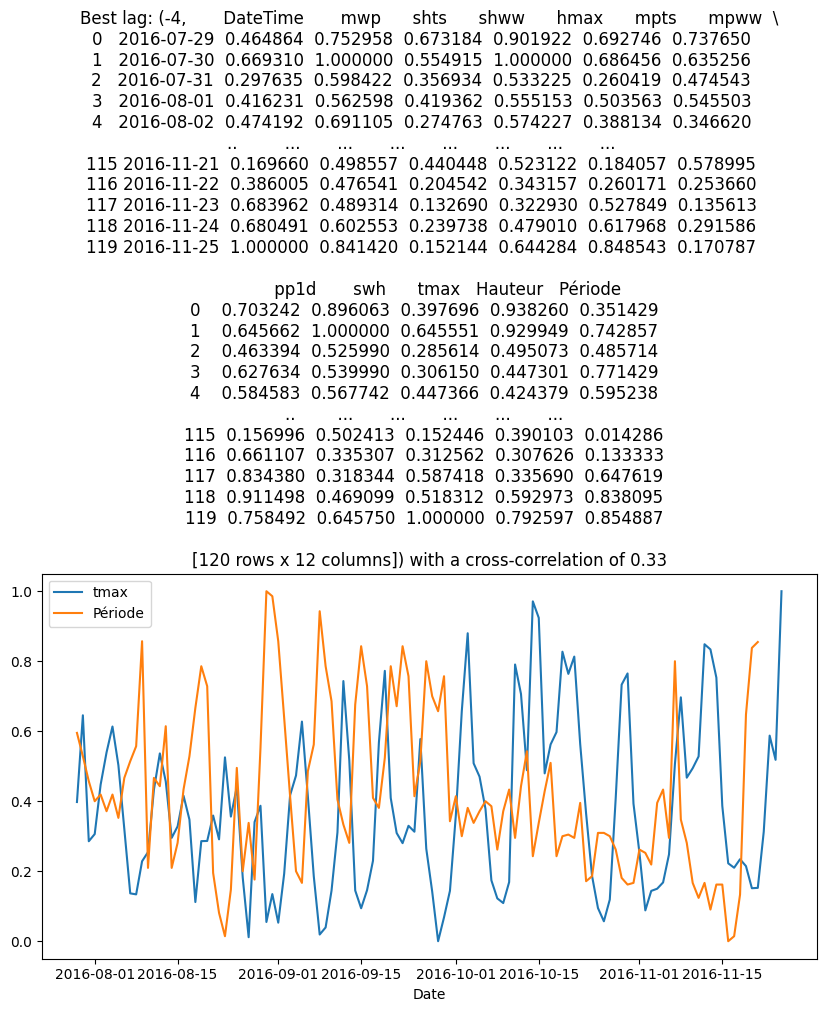

corrélation sans lag : 0.32612822420958665
rmse : 0.27709500055709974
corrélation avec lag : -0.3913240371711842
rmse : 4.091782470710881


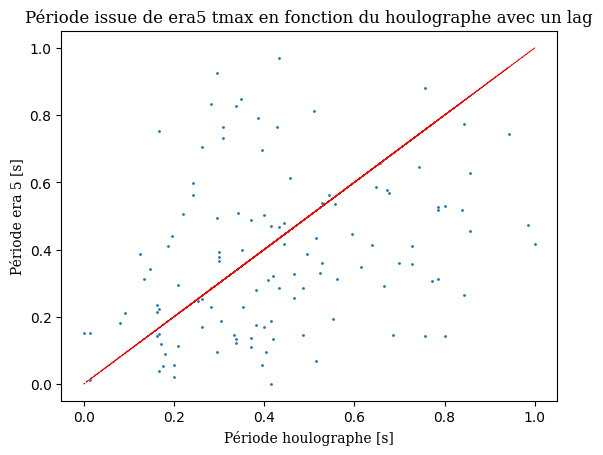

Lag for mpts is : 0


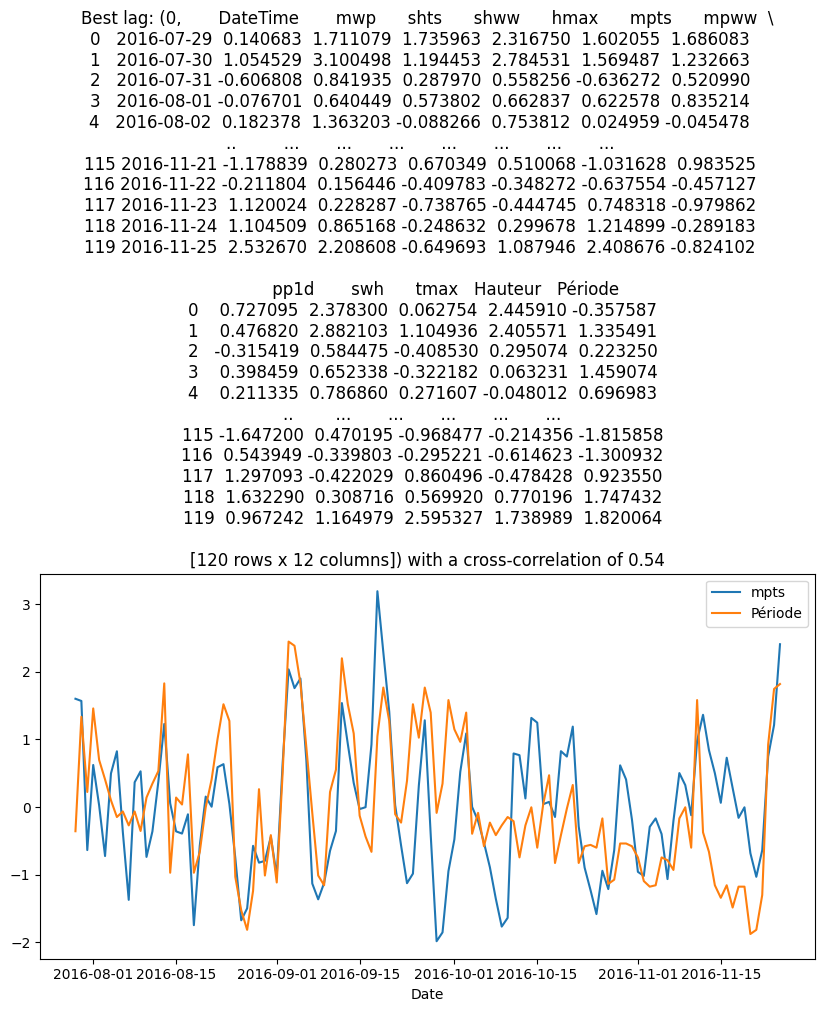

corrélation sans lag : 0.5359907594111616
rmse : 1.8611090706982725
corrélation avec lag : 0.5359907594111616
rmse : 1.8611090706982725


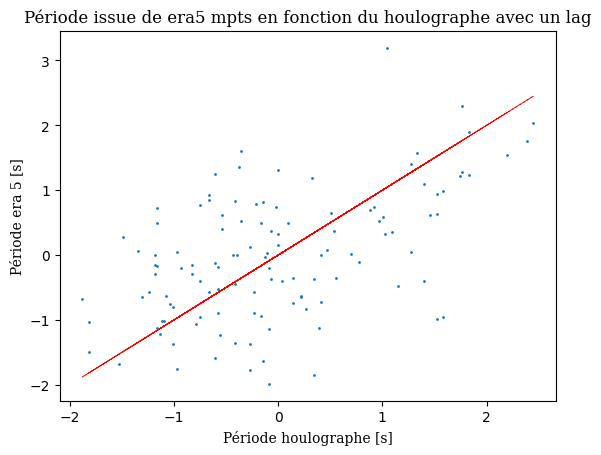

Lag for mpww is : -9


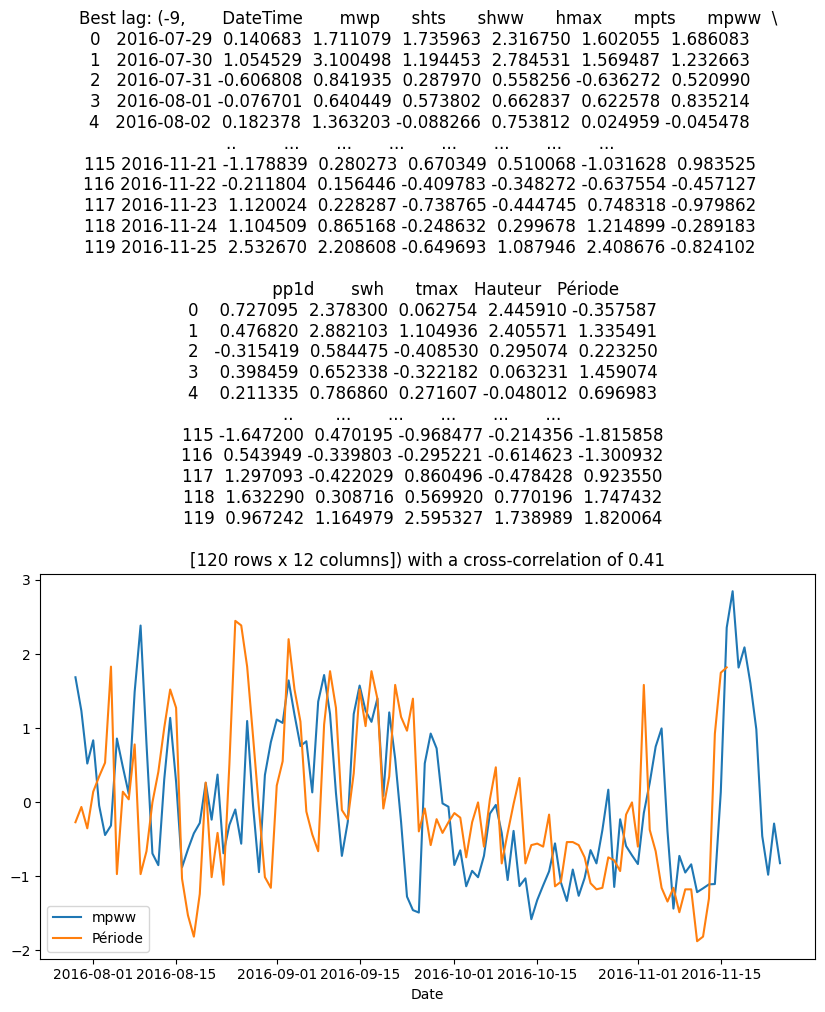

corrélation sans lag : -0.09700377849551572
rmse : 7.1981129357187355
corrélation avec lag : 0.40603631931704365
rmse : 7.061268404041718


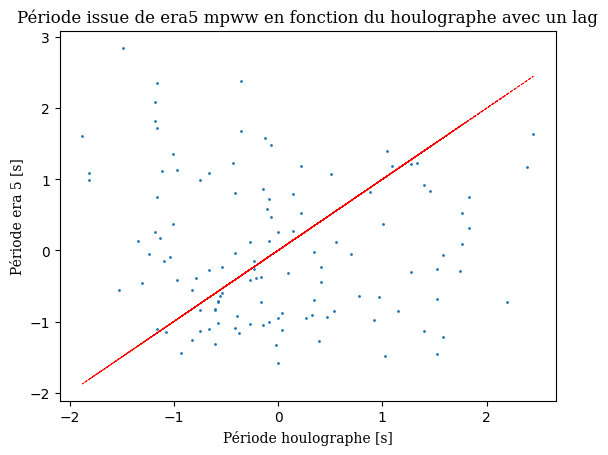

Lag for pp1d is : 0


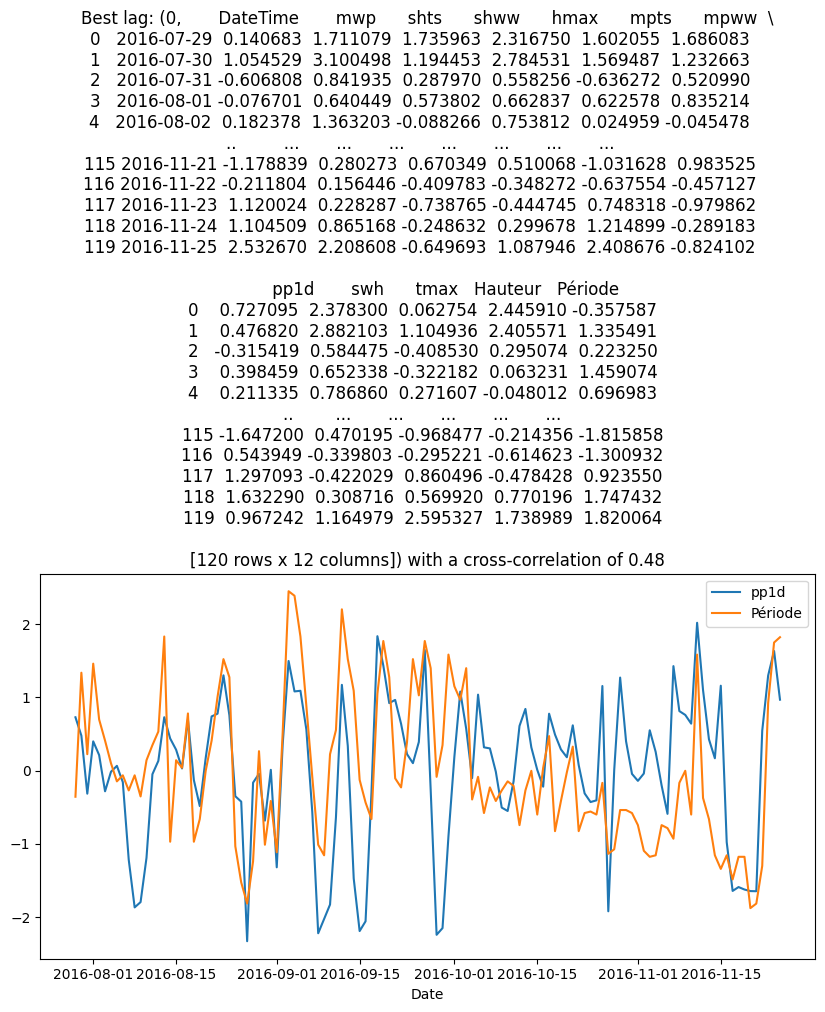

corrélation sans lag : 0.4831538662478872
rmse : 2.9071085290480205
corrélation avec lag : 0.4831538662478872
rmse : 2.9071085290480205


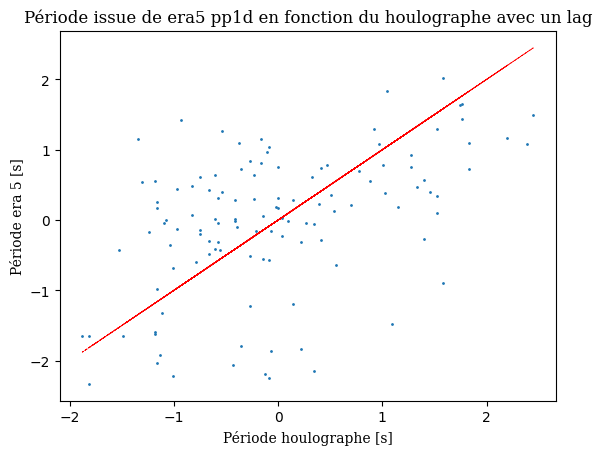

Lag for mwp is : 0


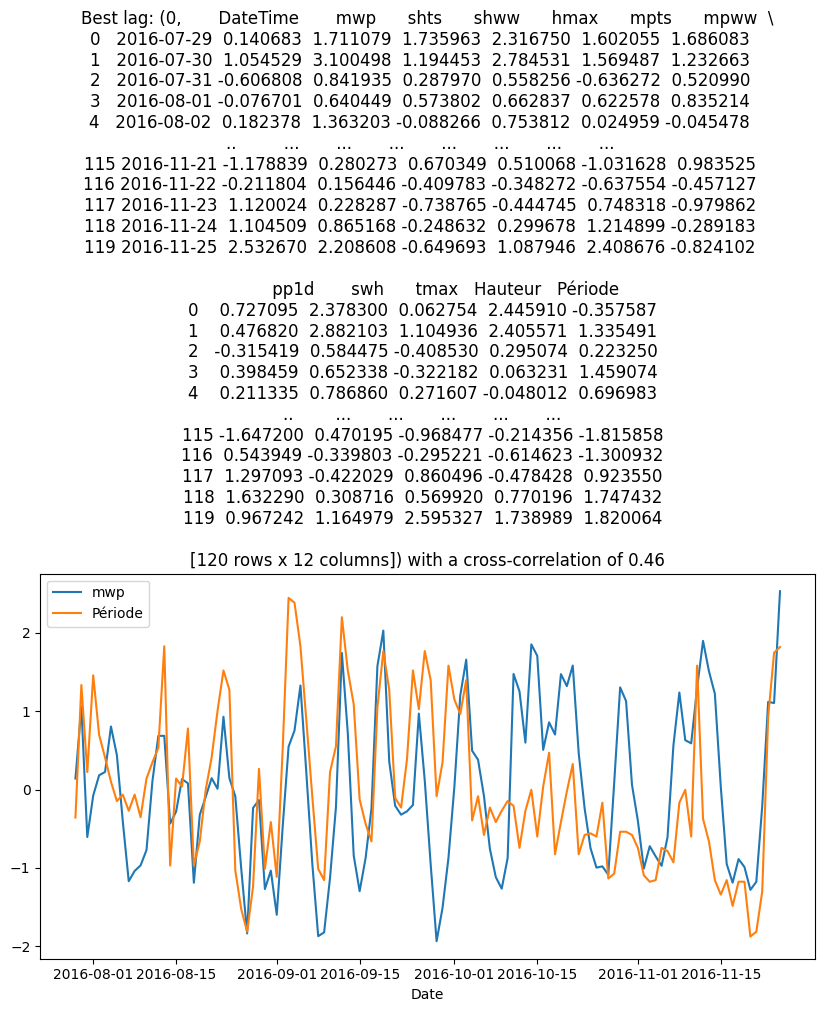

corrélation sans lag : 0.4622851224247768
rmse : 2.4362040902132764
corrélation avec lag : 0.4622851224247768
rmse : 2.4362040902132764


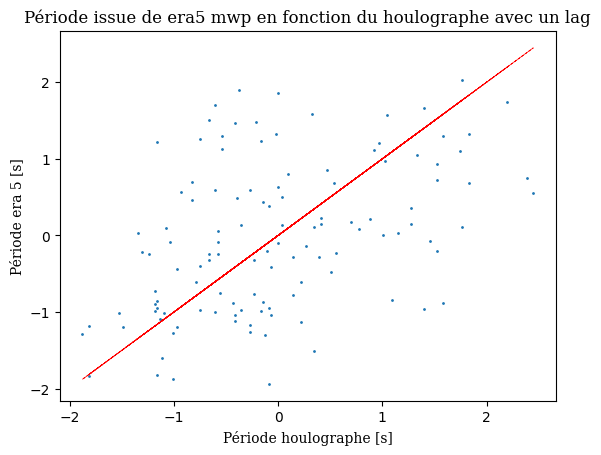

Lag for tmax is : -4


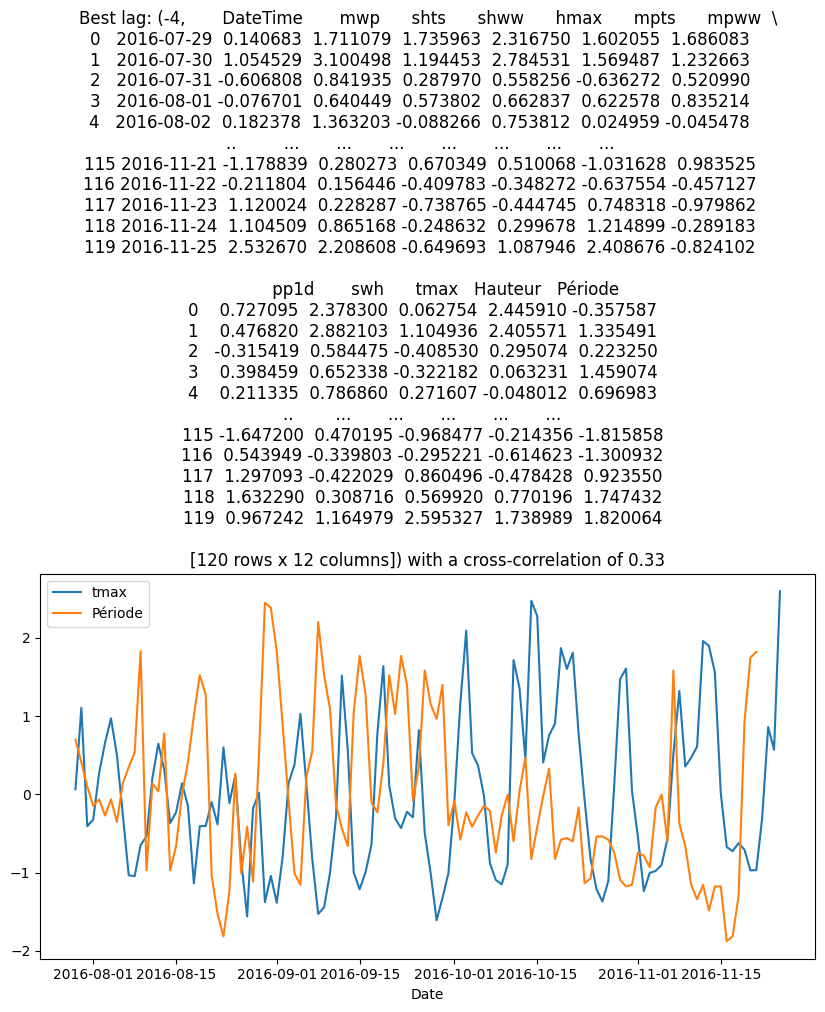

corrélation sans lag : 0.3261282242095866
rmse : 3.769903122886215
corrélation avec lag : -0.39132403717118414
rmse : 4.091782470710881


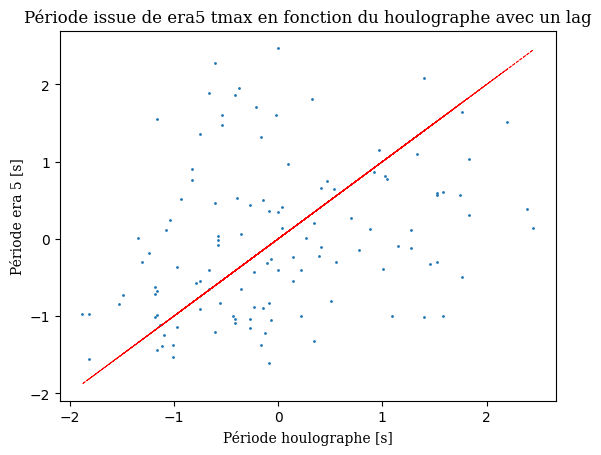

In [110]:
#Comparer les résultats des différentes mesures de era 5
data = wave_2016_era5.merge(nouv_houle_2016, on = 'DateTime')
data_norm_rescaled = data.copy()
column_n=data_norm_rescaled.columns[1:]
for column in column_n:
    # Transformation min/max
    data_norm_rescaled[column] = (data_norm_rescaled[column] - data_norm_rescaled[column].min()) / (data_norm_rescaled[column].max() - data_norm_rescaled[column].min())

data_norm_gaussienne = data.copy()
for column in column_n:
    # Transformation gaussienne
    transformer = StandardScaler().fit(data_norm_gaussienne[[column]])
    data_norm_gaussienne[column] = transformer.transform(data_norm_gaussienne[[column]])

L_height = ['hmax','shts','shww','swh']
L_period = ['mpts','mpww','pp1d','mwp','tmax']
for x in L_height :
    matrix_corr_height = cross_correlation(data_norm_rescaled,'Hauteur',x,15)
    lag = find_lag(matrix_corr_height)
    print('Lag for',x,'is :',lag)
    plot_with_best_lag(data_norm_rescaled,'Hauteur',x,15)
    plt.savefig('output/indicateur hauteur/'+x+' rescaled')
    plt.show()
    print("corrélation sans lag :", (np.corrcoef(data['Hauteur'],data[x])[0][1]))
    print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur']), data[x])))
    if lag <0:
        print("corrélation avec lag :", (np.corrcoef(data['Hauteur'].shift(lag)[:lag],data[x][:lag])[0][1]))
        print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].shift(lag)[:lag]),data[x][:lag])))
    else :
        print("corrélation avec lag :", (np.corrcoef(data['Hauteur'].shift(lag)[lag:],data[x][lag:])[0][1]))
        print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].shift(lag)[lag:]),data[x][lag:])))
    plt.scatter(data_norm_rescaled['Hauteur'][:-1], data_norm_rescaled[x].loc[:data_norm_rescaled.shape[0]-1][:-1], s = 1) #data ou data_norm
    plt.plot(data_norm_rescaled['Hauteur'][:-1], data_norm_rescaled['Hauteur'][:-1], color = 'r', linestyle = '--', linewidth = .6)
    plt.title('Hauteur issue de era5 '+x+' en fonction du houlographe avec un lag', fontfamily = 'serif')
    plt.xlabel('Hauteur houlographe [m]', fontfamily = 'serif')
    plt.ylabel('Hauteur era 5 [m] avec'+x, fontfamily = 'serif')
    plt.savefig('output/indicateur hauteur/'+x+' rescaled scatter plot')
    plt.show()

for x in L_height :
    matrix_corr_height = cross_correlation(data_norm_gaussienne,'Hauteur',x,15)
    lag = find_lag(matrix_corr_height)
    print('Lag for',x,'is :',lag)
    plot_with_best_lag(data_norm_gaussienne,'Hauteur',x,15)
    plt.savefig('output/indicateur hauteur/'+x+' normalized')
    plt.show()
    print("corrélation sans lag :", (np.corrcoef(data['Hauteur'],data[x])[0][1]))
    print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur']), data[x])))
    if lag <0:
        print("corrélation avec lag :", (np.corrcoef(data['Hauteur'].shift(lag)[:lag],data[x][:lag])[0][1]))
        print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].shift(lag)[:lag]),data[x][:lag])))
    else :
        print("corrélation avec lag :", (np.corrcoef(data['Hauteur'].shift(lag)[lag:],data[x][lag:])[0][1]))
        print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].shift(lag)[lag:]),data[x][lag:])))
    plt.scatter(data_norm_gaussienne['Hauteur'][:-1], data_norm_gaussienne[x].loc[:data_norm_gaussienne.shape[0]-1][:-1], s = 1) #data ou data_norm
    plt.plot(data_norm_gaussienne['Hauteur'][:-1], data_norm_gaussienne['Hauteur'][:-1], color = 'r', linestyle = '--', linewidth = .6)
    plt.title('Hauteur issue de era5 '+x+' en fonction du houlographe avec un lag', fontfamily = 'serif')
    plt.xlabel('Hauteur houlographe [m]', fontfamily = 'serif')
    plt.ylabel('Hauteur era 5 [m] avec'+x, fontfamily = 'serif')
    plt.savefig('output/indicateur hauteur/'+x+' normalized scatter plot')
    plt.show()

for x in L_period :
    matrix_corr_period = cross_correlation(data_norm_rescaled,'Période',x,15)
    lag = find_lag(matrix_corr_period)
    print('Lag for',x,'is :',lag)
    plot_with_best_lag(data_norm_rescaled,'Période',x,15)
    plt.savefig('output/indicateur période/'+x+'rescaled')
    plt.show()
    print("corrélation sans lag :", (np.corrcoef(data_norm_rescaled['Période'],data_norm_rescaled[x])[0][1]))
    print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data_norm_rescaled['Période']), data_norm_rescaled[x])))
    if lag<0:
        print("corrélation avec lag :", (np.corrcoef(data_norm_rescaled['Période'].shift(lag)[:lag],data_norm_rescaled[x][:lag])[0][1]))
        print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].shift(lag)[:lag]),data[x][:lag])))
    else :
        print("corrélation avec lag :", (np.corrcoef(data_norm_rescaled['Période'].shift(lag)[lag:],data_norm_rescaled[x][lag:])[0][1]))
        print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].shift(lag)[lag:]),data[x][lag:])))
    plt.scatter(data_norm_rescaled['Période'][:-1], data_norm_rescaled[x].loc[:data.shape[0]-1][:-1], s = 1)
    plt.plot(data_norm_rescaled['Période'][:-1], data_norm_rescaled['Période'][:-1], color = 'r', linestyle = '--', linewidth = .6)
    plt.title('Période issue de era5 '+x+' en fonction du houlographe avec un lag', fontfamily = 'serif')
    plt.xlabel('Période houlographe [s]', fontfamily = 'serif')
    plt.ylabel('Période era 5 [s]', fontfamily = 'serif')
    plt.savefig('output/indicateur période/'+x+' rescaled scatter plot')
    plt.show() 

for x in L_period :
    matrix_corr_period = cross_correlation(data_norm_gaussienne,'Période',x,15)
    lag = find_lag(matrix_corr_period)
    print('Lag for',x,'is :',lag)
    plot_with_best_lag(data_norm_gaussienne,'Période',x,15)
    plt.savefig('output/indicateur période/'+x+' normalized')
    plt.show()
    print("corrélation sans lag :", (np.corrcoef(data['Période'],data[x])[0][1]))
    print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période']), data[x])))
    if lag<0:
        print("corrélation avec lag :", (np.corrcoef(data['Période'].shift(lag)[:lag],data[x][:lag])[0][1]))
        print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].shift(lag)[:lag]),data[x][:lag])))
    else :
        print("corrélation avec lag :", (np.corrcoef(data['Période'].shift(lag)[lag:],data[x][lag:])[0][1]))
        print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].shift(lag)[lag:]),data[x][lag:])))
    plt.scatter(data_norm_gaussienne['Période'][:-1], data_norm_gaussienne[x].loc[:data.shape[0]-1][:-1], s = 1)
    plt.plot(data_norm_gaussienne['Période'][:-1], data_norm_gaussienne['Période'][:-1], color = 'r', linestyle = '--', linewidth = .6)
    plt.title('Période issue de era5 '+x+' en fonction du houlographe avec un lag', fontfamily = 'serif')
    plt.xlabel('Période houlographe [s]', fontfamily = 'serif')
    plt.ylabel('Période era 5 [s]', fontfamily = 'serif')
    plt.savefig('output/indicateur période/'+x+' normalized scatter plot')
    plt.show() 

Conclusion : la mesure la plus adaptée pour la hauteur est swh (avec un lag de 1), pour la période c'est mpts (sans lag)

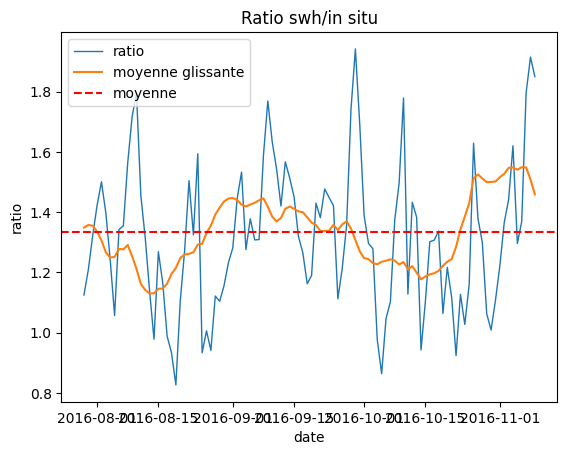

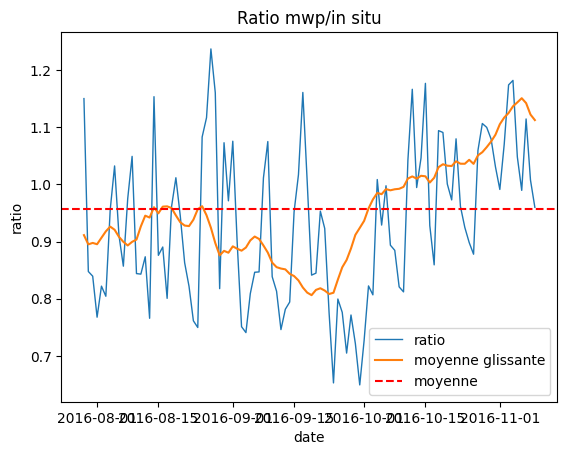

In [111]:
#Pour la hauteur
ratio = data['swh']/data['Hauteur']
dispersion = (data['swh']) - (data['Hauteur'])

# Paramètre de la moyenne mobile
window_size = 17

x = np.array(ratio)
x_smoothed = moving_average(x.squeeze(), window_size)
y = np.array(dispersion)
y_smoothed = moving_average(y.squeeze(), window_size)

plt.plot(data['DateTime'].loc[:ratio.shape[0] - window_size], ratio.loc[:ratio.shape[0] - window_size], linewidth = 1, label = 'ratio')
plt.plot(data['DateTime'].loc[:ratio.shape[0] - window_size],x_smoothed, label = 'moyenne glissante')
plt.axhline(y=ratio.mean(), color='r', linestyle='--', label = 'moyenne')
plt.title('Ratio swh/in situ')
plt.xlabel('date')
plt.ylabel('ratio')
plt.legend()
plt.savefig('output/Ratios/Ratio swh & in situ')
plt.show()


#Pour la période
ratio = data['mpts']/data['Période']
dispersion = (data['mpts']) - (data['Période'])

# Paramètres de la moyenne mobile
window_size = 17

x = np.array(ratio)
x_smoothed = moving_average(x.squeeze(), window_size)
y = np.array(dispersion)
y_smoothed = moving_average(y.squeeze(), window_size)

plt.plot(data['DateTime'].loc[:ratio.shape[0] - window_size], ratio.loc[:ratio.shape[0] - window_size], linewidth = 1, label = 'ratio')
plt.plot(data['DateTime'].loc[:ratio.shape[0] - window_size],x_smoothed, label = 'moyenne glissante')
plt.axhline(y=ratio.mean(), color='r', linestyle='--', label = 'moyenne')
plt.title('Ratio mwp/in situ')
plt.xlabel('date')
plt.ylabel('ratio')
plt.legend()
plt.savefig('output/Ratios/Ratio mwp & in situ')
plt.show()


# Regression linéaire

Pour la hauteur

Pente (coefficient) : 0.7437462243854521
Ordonnée à l'origine : 0.0881028045075547
r2 : 0.5815746478270791
rmse : 0.33111325298978617


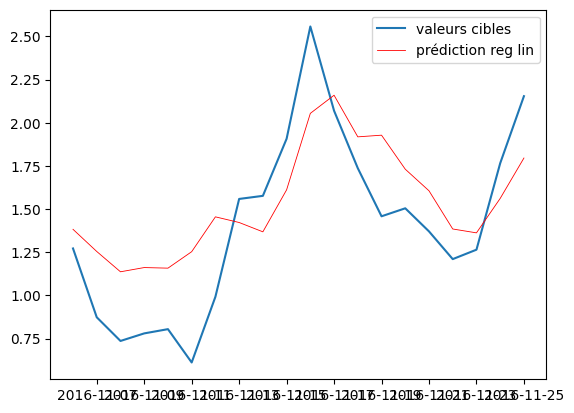

In [112]:
longueur = 100
# Train
X_train = np.array(data['swh'].iloc[:longueur]).reshape(-1, 1)
Y_train = np.array(data['Hauteur'].iloc[:longueur])

#Test
X_test = np.array(data['swh'].iloc[longueur:120]).reshape(-1, 1)

model = linear_model.LinearRegression()

model.fit(X_train, Y_train)

#Pente & ordonnée à l'origine
slope = model.coef_[0]
intercept = model.intercept_

# Redressez Y en fonction de X
Y_test = slope * X_test + intercept

# Affichez les résultats
print("Pente (coefficient) :", slope)
print("Ordonnée à l'origine :", intercept)
print("r2 :", metrics.r2_score(np.array(data['Hauteur'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].iloc[longueur:120]), Y_test)))

plt.plot(data['DateTime'].iloc[longueur:120],data['Hauteur'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], slope * X_test + intercept, color = 'r', linewidth = .6, label = 'prédiction reg lin')
plt.legend()

Pour la période

Pente (coefficient) : 1.1611574454419695
Ordonnée à l'origine : -0.5817135980193111
r2 : -0.0629637935010463
rmse : 2.3414521067006255


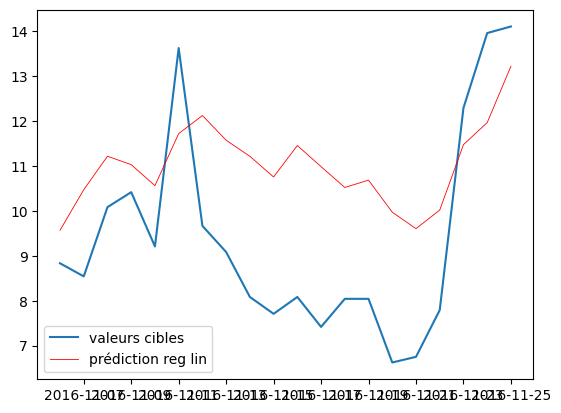

In [113]:
longueur = 100
# Train
X_train = np.array(data['mpts'].iloc[:longueur]).reshape(-1, 1)
Y_train = np.array(data['Période'].iloc[:longueur])

#Test
X_test = np.array(data['mpts'].iloc[longueur:120]).reshape(-1, 1)

model = linear_model.LinearRegression()

model.fit(X_train, Y_train)

#Pente & ordonnée à l'origine
slope = model.coef_[0]
intercept = model.intercept_

# Redressez Y en fonction de X
Y_test = slope * X_test + intercept

# Affichez les résultats
print("Pente (coefficient) :", slope)
print("Ordonnée à l'origine :", intercept)
print("r2 :", metrics.r2_score(np.array(data['Période'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].iloc[longueur:120]), Y_test)))

plt.plot(data['DateTime'].iloc[longueur:120],data['Période'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], slope * X_test + intercept, color = 'r', linewidth = .6, label = 'prédiction reg lin')
plt.legend()

CONCLUSION : très mauvais

# Régression polynomiale

Hauteur

r2 : 0.5807219064258863
rmse : 0.3314504819202154


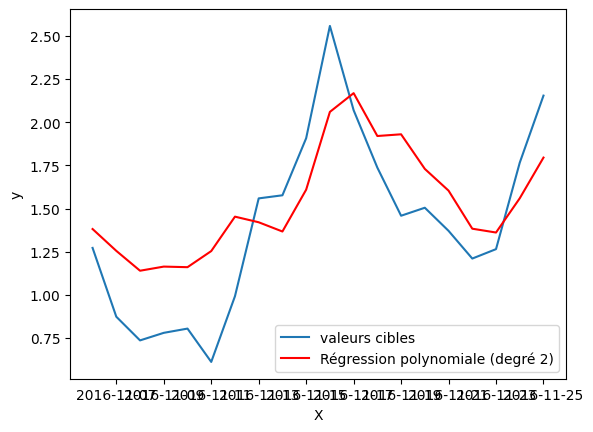

In [114]:
longueur = 100

# Train
X_train = np.array(data['swh'].iloc[:longueur]).reshape(-1, 1)
Y_train = np.array(data['Hauteur'].iloc[:longueur])

#Test
X_test = np.array(data['swh'][longueur:120]).reshape(-1, 1)

poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly_features.fit_transform(X_train)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y_train)

# Test
X_test_poly = poly_features.transform(X_test)
Y_test = lin_reg.predict(X_test_poly)

# Erreur
print("r2 :", metrics.r2_score(np.array(data['Hauteur'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].iloc[longueur:120]), Y_test)))

# Tracer les données et la courbe de régression polynomiale
plt.plot(data['DateTime'].iloc[longueur:120],data['Hauteur'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], Y_test, 'r-', label='Régression polynomiale (degré 2)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


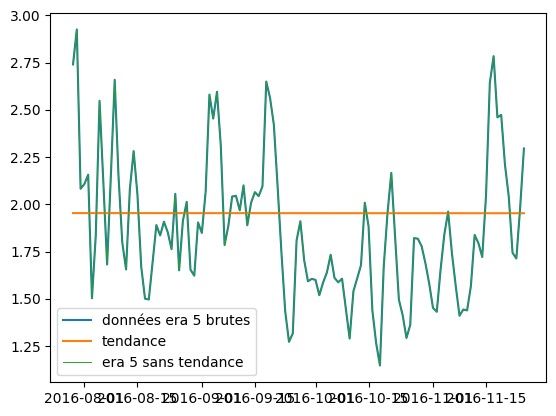

In [115]:
# detrending era 5
temps_numerique = np.arange(wave_era5.shape[0])

# Ajuster une régression linéaire
model = LinearRegression()
model.fit(temps_numerique.reshape(-1, 1), np.array(wave_era5['swh']))

# Obtenir les coefficients de la tendance linéaire
pente = model.coef_[0]
intercept = model.intercept_

plt.plot(data['DateTime'], data['swh'], label = 'données era 5 brutes')
plt.plot(data['DateTime'], pente * temps_numerique[:data.shape[0]] + intercept, label = 'tendance')
plt.plot(data['DateTime'], data['swh'] - pente * temps_numerique[:data.shape[0]], linewidth = .7, label = 'era 5 sans tendance')
plt.legend()

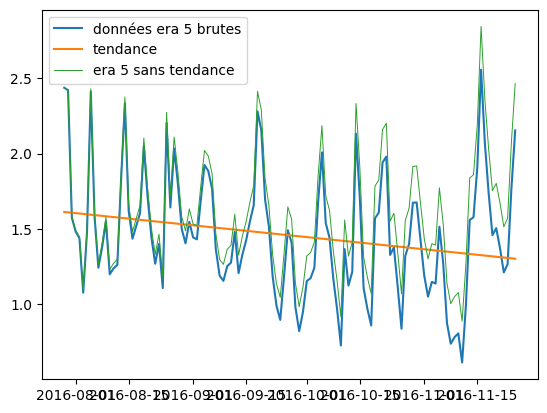

In [116]:
# detrending données capteur
temps_numerique_capt = np.arange(data.shape[0])

# Ajuster une régression linéaire
model_capt = LinearRegression()
model_capt.fit(temps_numerique_capt.reshape(-1, 1), np.array(data['Hauteur']))

# Obtenir les coefficients de la tendance linéaire
pente_capt = model_capt.coef_[0]
intercept_capt = model_capt.intercept_

plt.plot(data['DateTime'], data['Hauteur'], label = 'données era 5 brutes')
plt.plot(data['DateTime'], pente_capt * temps_numerique_capt + intercept_capt, label = 'tendance')
plt.plot(data['DateTime'], data['Hauteur'] - pente_capt * temps_numerique_capt, linewidth = .7, label = 'era 5 sans tendance')
plt.legend()

r2 : 0.3415927914725775
rmse : 0.41535061451705835


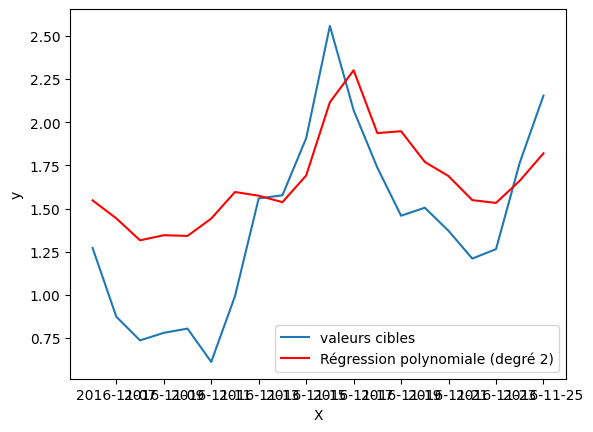

In [117]:
longueur = 100

# Train
X_train = np.array((data['swh'] - pente * temps_numerique[:data.shape[0]]).loc[:longueur]).reshape(-1, 1)
Y_train = np.array((data['Hauteur'] - pente_capt * temps_numerique_capt).loc[:longueur])

#Test
X_test = np.array(data['swh'] - pente * temps_numerique[:data.shape[0]])[longueur:].reshape(-1, 1)

# Créer un objet PolynomialFeatures pour transformer les caractéristiques
poly_features = PolynomialFeatures(degree=3, include_bias=True)
X_poly = poly_features.fit_transform(X_train)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y_train)

# Test
X_test_poly = poly_features.transform(X_test)
Y_test = lin_reg.predict(X_test_poly)

# Erreur
print("r2 :", metrics.r2_score(np.array(data['Hauteur'].loc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].loc[longueur:120]), Y_test)))

plt.plot(data['DateTime'].loc[longueur:120],data['Hauteur'].loc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].loc[longueur:120], Y_test, 'r-', label='Régression polynomiale (degré 2)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Bizarre : moins bon

Période

r2 : -0.0016740670394397306
rmse : 2.272946733040495


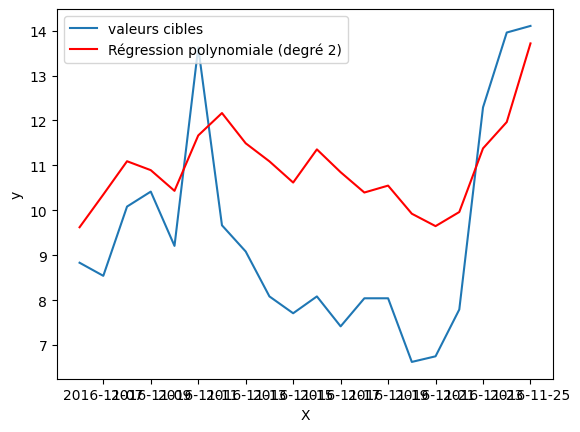

In [118]:
longueur = 100

# Train
X_train = np.array(data['mpts'].iloc[:longueur]).reshape(-1, 1)
Y_train = np.array(data['Période'].iloc[:longueur])

#Test
X_test = np.array(data['mpts'][longueur:120]).reshape(-1, 1)

poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly_features.fit_transform(X_train)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y_train)

# Test
X_test_poly = poly_features.transform(X_test)
Y_test = lin_reg.predict(X_test_poly)

# Erreur
print("r2 :", metrics.r2_score(np.array(data['Période'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].iloc[longueur:120]), Y_test)))

# Tracer les données et la courbe de régression polynomiale
plt.plot(data['DateTime'].iloc[longueur:120],data['Période'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], Y_test, 'r-', label='Régression polynomiale (degré 2)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

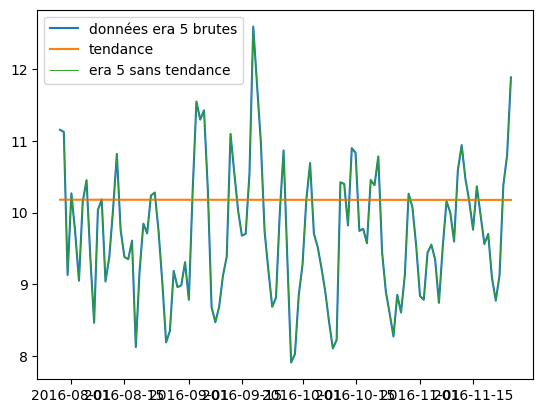

In [119]:
# detrending era 5
temps_numerique = np.arange(wave_era5.shape[0])

# Ajuster une régression linéaire
model = LinearRegression()
model.fit(temps_numerique.reshape(-1, 1), np.array(wave_era5['mpts']))

# Obtenir les coefficients de la tendance linéaire
pente = model.coef_[0]
intercept = model.intercept_

plt.plot(data['DateTime'], data['mpts'], label = 'données era 5 brutes')
plt.plot(data['DateTime'], pente * temps_numerique[:data.shape[0]] + intercept, label = 'tendance')
plt.plot(data['DateTime'], data['mpts'] - pente * temps_numerique[:data.shape[0]], linewidth = .7, label = 'era 5 sans tendance')
plt.legend()

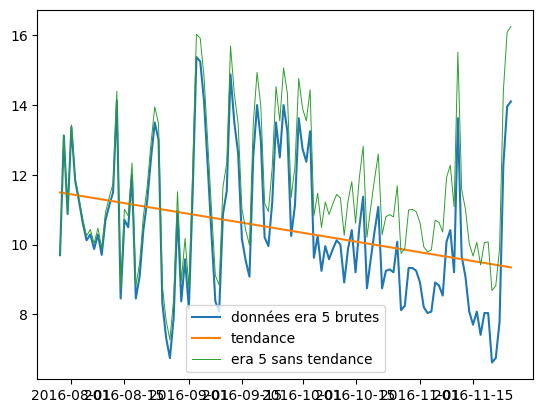

In [120]:
# detrending données capteur
temps_numerique_capt = np.arange(data.shape[0])

# Ajuster une régression linéaire
model_capt = LinearRegression()
model_capt.fit(temps_numerique_capt.reshape(-1, 1), np.array(data['Période']))

# Obtenir les coefficients de la tendance linéaire
pente_capt = model_capt.coef_[0]
intercept_capt = model_capt.intercept_

plt.plot(data['DateTime'], data['Période'], label = 'données era 5 brutes')
plt.plot(data['DateTime'], pente_capt * temps_numerique_capt + intercept_capt, label = 'tendance')
plt.plot(data['DateTime'], data['Période'] - pente_capt * temps_numerique_capt, linewidth = .7, label = 'era 5 sans tendance')
plt.legend()

r2 : -0.6884354263276793
rmse : 2.9509936221785122


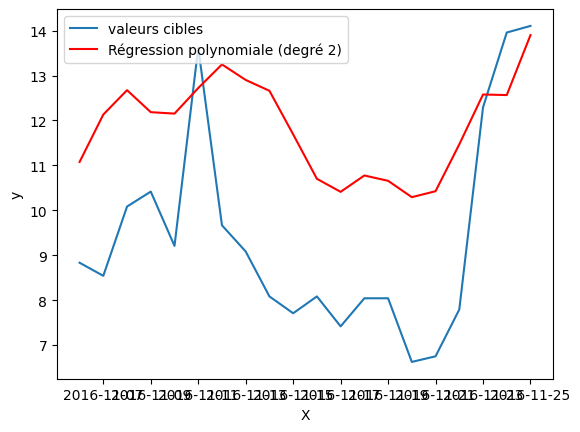

In [121]:
longueur = 100

# Train
X_train = np.array((data['mwp'] - pente * temps_numerique[:data.shape[0]]).loc[:longueur]).reshape(-1, 1)
Y_train = np.array((data['Période'] - pente_capt * temps_numerique_capt).loc[:longueur])

#Test
X_test = np.array(data['mwp'] - pente * temps_numerique[:data.shape[0]])[longueur:].reshape(-1, 1)

# Créer un objet PolynomialFeatures pour transformer les caractéristiques
poly_features = PolynomialFeatures(degree=3, include_bias=True)
X_poly = poly_features.fit_transform(X_train)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y_train)

# Test
X_test_poly = poly_features.transform(X_test)
Y_test = lin_reg.predict(X_test_poly)

# Erreur
print("r2 :", metrics.r2_score(np.array(data['Période'].loc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].loc[longueur:120]), Y_test)))

plt.plot(data['DateTime'].loc[longueur:120],data['Période'].loc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].loc[longueur:120], Y_test, 'r-', label='Régression polynomiale (degré 2)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

toujours mauvais pour la période

# Filtre

Hauteur

In [122]:
r = 2
len_train = 100-r
N = data.shape[0]

X_train = np.ones((len_train, (2*r + 1) + 1)) #rajout du biais
for j in range((2*r + 1) - 1):
    X_train[:, j] = np.roll(data['swh'].iloc[:len_train], r - j)

Y = np.array(data['Hauteur'].iloc[:len_train]).reshape(-1, 1)

X_test = np.ones((N - len_train-r, (2*r + 1) + 1)) #rajout du biais
for j in range((2*r + 1) - 1):
    X_test[:, j] = np.roll(data['swh'].iloc[len_train+r:N], r - j)
h, residuals, _, _ = np.linalg.lstsq(X_train, Y, rcond=None)
print("corrélation :", np.corrcoef(np.array(data['Hauteur'].iloc[longueur:N]).reshape(1, N-100),np.dot(X_test, h).reshape(1, N-100))[0, 1])
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].loc[len_train+r:N]), np.dot(X_test, h))))

corrélation : 0.843635418977191
rmse : 0.3309138623480566


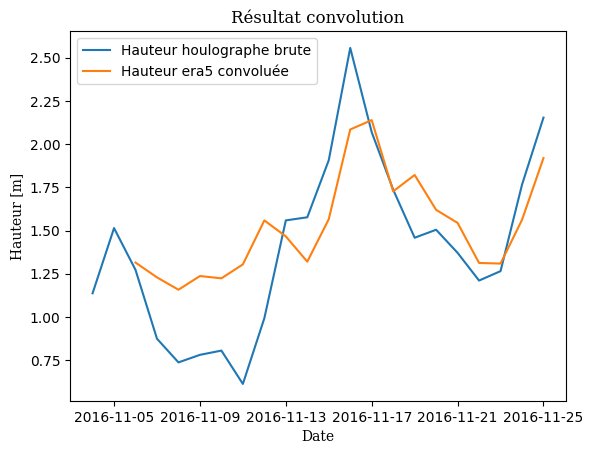

In [123]:
plt.plot(data['DateTime'].loc[len_train:], data['Hauteur'].loc[len_train:], label = 'Hauteur houlographe brute')
plt.plot(data['DateTime'].iloc[len_train+r:data.shape[0]], np.dot(X_test, h), label = 'Hauteur era5 convoluée')
plt.title('Résultat convolution', fontfamily = 'serif')
plt.xlabel('Date', fontfamily = 'serif')
plt.ylabel('Hauteur [m]', fontfamily = 'serif')
plt.legend()
#plt.savefig('output/Filtre/Résultat convolution hauteur')

Période

In [124]:
r = 15
len_train = 100-r
N = data.shape[0]
X_train = np.ones((len_train, (2*r + 1) + 1)) #rajout du biais
for j in range((2*r + 1) - 1):
    X_train[:, j] = np.roll(data['mpts'].iloc[:len_train], r - j)

Y = np.array(data['Période'].iloc[:len_train]).reshape(-1, 1)
Y.shape

X_test = np.ones((N - len_train-r, (2*r + 1) + 1)) #rajout du biais
for j in range((2*r + 1) - 1):
    X_test[:, j] = np.roll(data['mpts'].iloc[len_train+r:N], r - j)
h, residuals, _, _ = np.linalg.lstsq(X_train, Y, rcond=None)
print("corrélation :", np.corrcoef(np.array(data['Période'].iloc[longueur:N]).reshape(1, N-100),np.dot(X_test, h).reshape(1, N-100))[0, 1])
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].loc[len_train+r:N]), np.dot(X_test, h))))

corrélation : 0.377361083535313
rmse : 3.161332181670754


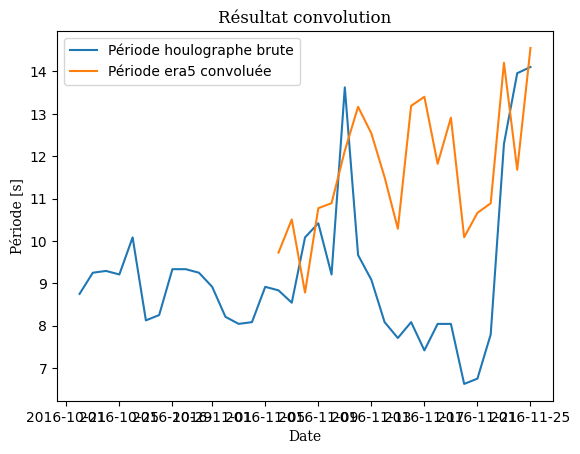

In [125]:
plt.plot(data['DateTime'].loc[len_train:], data['Période'].loc[len_train:], label = 'Période houlographe brute')
plt.plot(data['DateTime'].iloc[len_train+r:data.shape[0]], np.dot(X_test, h), label = 'Période era5 convoluée')
plt.title('Résultat convolution', fontfamily = 'serif')
plt.xlabel('Date', fontfamily = 'serif')
plt.ylabel('Période [s]', fontfamily = 'serif')
plt.legend()
#plt.savefig('output/Filtre/Résultat convolution période')

# Prédiction de l'erreur

Régression linéaire en fonction de la hauteur

Pente (coefficient) : 0.3210787420017447
Ordonnée à l'origine : -0.8573645846676685
r2 : 0.16406774131629753
rmse : 0.25499226493232585


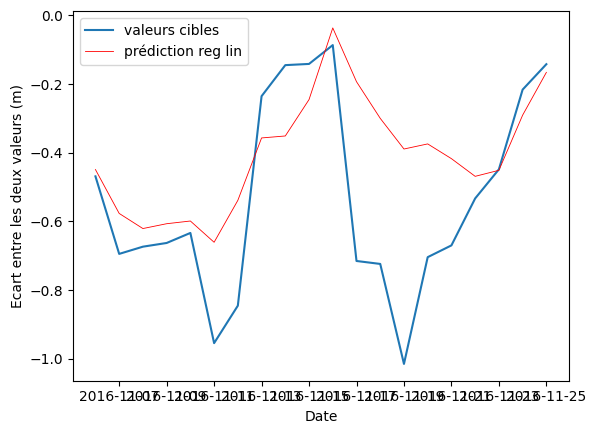

In [126]:
longueur = 100
# Train
X_train = np.array(data['Hauteur'].iloc[:longueur]).reshape(-1, 1)
Y_train = np.array(data['Hauteur'].iloc[:longueur]-data['swh'].iloc[:longueur])

#Test
X_test = np.array(data['Hauteur'].iloc[longueur:120]).reshape(-1, 1)

model = linear_model.LinearRegression()

model.fit(X_train, Y_train)

#Pente & ordonnée à l'origine
slope = model.coef_[0]
intercept = model.intercept_

# Redressez Y en fonction de X
Y_test = slope * X_test + intercept

# Affichez les résultats
print("Pente (coefficient) :", slope)
print("Ordonnée à l'origine :", intercept)
print("r2 :", metrics.r2_score(np.array(data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120]), Y_test)))

plt.plot(data['DateTime'].iloc[longueur:120],data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], slope * X_test + intercept, color = 'r', linewidth = .6, label = 'prédiction reg lin')
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (m)')
plt.legend()

Pente (coefficient) : 0.7282287353963982
Ordonnée à l'origine : -6.763465516971684
r2 : 0.7830675824293472
rmse : 0.8294703159778987


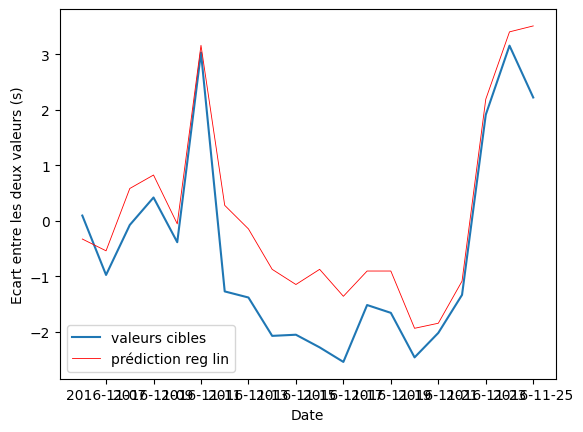

In [127]:
longueur= 100
# Train
X_train = np.array(data['Période'].iloc[:longueur]).reshape(-1, 1)
Y_train = np.array(data['Période'].iloc[:longueur]-data['mpts'].iloc[:longueur])

#Test
X_test = np.array(data['Période'].iloc[longueur:120]).reshape(-1, 1)

model = linear_model.LinearRegression()

model.fit(X_train, Y_train)

#Pente & ordonnée à l'origine
slope = model.coef_[0]
intercept = model.intercept_

# Redressez Y en fonction de X
Y_test = slope * X_test + intercept

# Affichez les résultats
print("Pente (coefficient) :", slope)
print("Ordonnée à l'origine :", intercept)
print("r2 :", metrics.r2_score(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test)))

plt.plot(data['DateTime'].iloc[longueur:120],data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], slope * X_test + intercept, color = 'r', linewidth = .6, label = 'prédiction reg lin')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (s)')
plt.savefig('output/predire erreur/Période linéaire')

Pente (coefficient) : 2.6795648776870244
Ordonnée à l'origine : -24.886610167696322
r2 : -1.9370908866651786
rmse : 3.0520898417562345


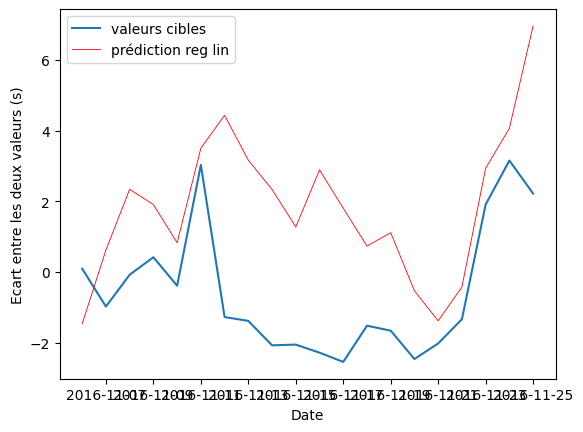

In [128]:
slope2=slope/(1-slope)
intercept2 = intercept/(1-slope)
# Redressez Y en fonction de X
X_test2= np.array(data['mpts'].iloc[longueur:120]).reshape(-1, 1)
Y_test2 = slope2 * X_test2 + intercept2

# Affichez les résultats
print("Pente (coefficient) :", slope2)
print("Ordonnée à l'origine :", intercept2)
print("r2 :", metrics.r2_score(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test2))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test2)))

plt.plot(data['DateTime'].iloc[longueur:120],data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], slope2 * X_test2 + intercept2, color = 'r', linewidth = .6, label = 'prédiction reg lin')
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (s)')
plt.legend()

Regression polynomiale en fonction de la hauteur

r2 : -454.53093558090836
rmse : 5.952513675852963


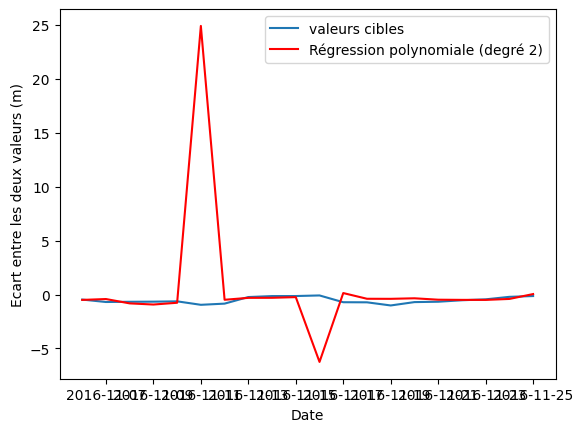

In [129]:
longueur= 100

# Train
X_train = np.array(data['Hauteur'].iloc[:longueur]).reshape(-1, 1)
Y_train = np.array(data['Hauteur'].iloc[:longueur]-data['swh'].iloc[:longueur])

#Test
X_test = np.array(data['Hauteur'][longueur:120]).reshape(-1, 1)

poly_features = PolynomialFeatures(degree=12, include_bias=False)
X_poly = poly_features.fit_transform(X_train)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y_train)

# Test
X_test_poly = poly_features.transform(X_test)
Y_test = lin_reg.predict(X_test_poly)

# Erreur
print("r2 :", metrics.r2_score(np.array(data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120]), Y_test)))

# Tracer les données et la courbe de régression polynomiale
plt.plot(data['DateTime'].iloc[longueur:120],data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], Y_test, 'r-', label='Régression polynomiale (degré 2)')
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (m)')
plt.legend()
plt.show()

r2 : 0.738560621956727
rmse : 0.9105926099358672


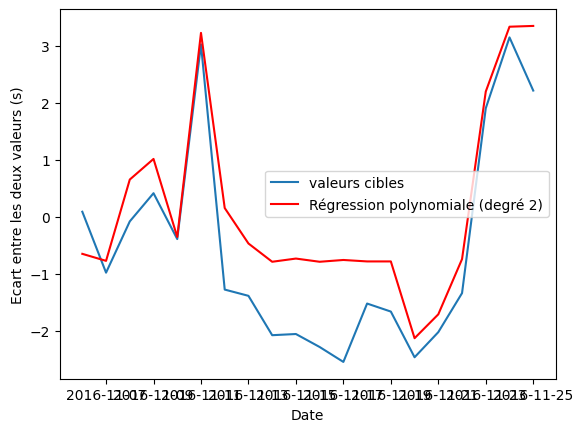

In [130]:
longueur= 100

# Train
X_train = np.array(data['Période'].iloc[:longueur]).reshape(-1, 1)
Y_train = np.array(data['Période'].iloc[:longueur]-data['mpts'].iloc[:longueur])

#Test
X_test = np.array(data['Période'][longueur:120]).reshape(-1, 1)

poly_features = PolynomialFeatures(degree=12, include_bias=False)
X_poly = poly_features.fit_transform(X_train)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y_train)

# Test
X_test_poly = poly_features.transform(X_test)
Y_test = lin_reg.predict(X_test_poly)

# Erreur
print("r2 :", metrics.r2_score(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test)))

# Tracer les données et la courbe de régression polynomiale
plt.plot(data['DateTime'].iloc[longueur:120],data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], Y_test, 'r-', label='Régression polynomiale (degré 2)')
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (s)')
plt.legend()
plt.show()

Régression multiple en fonction de la hauteur, de la période et de leur carré

r2 : 0.3245226777196135
rmse : 0.22894953149363073


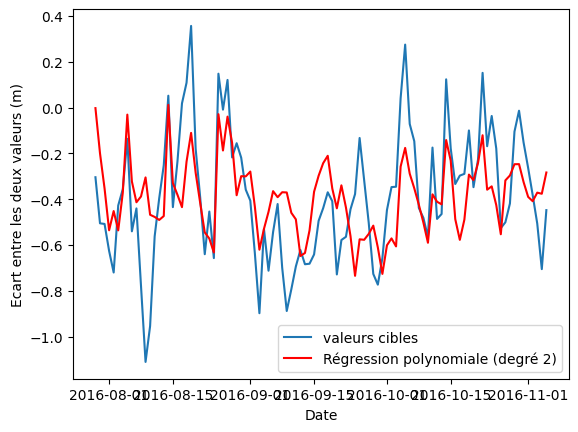

r2 : -0.38270746896325836
rmse : 0.32794923215589844


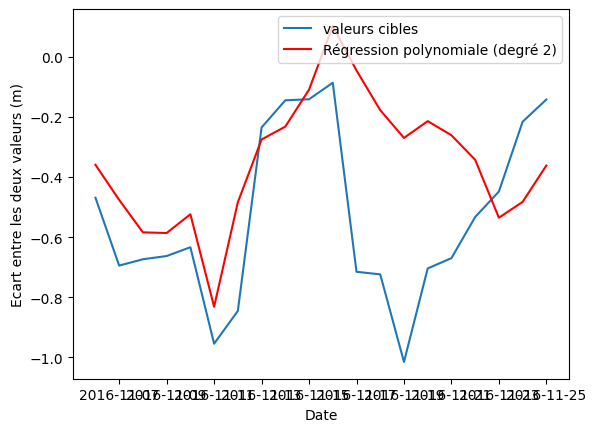

In [131]:
longueur= 100

# Train
X_train = [np.array(data['Hauteur'].iloc[:longueur]),np.array((data['Hauteur']**2).iloc[:longueur]),np.array(data['Période'].iloc[:longueur]),np.array((data['Période']**2).iloc[:longueur])]
Y_train = np.array(data['Hauteur'].iloc[:longueur]-data['swh'].iloc[:longueur])

X_train=np.transpose(X_train)
X_train=np.c_[X_train,np.ones(X_train.shape[0])]
m=np.linalg.lstsq(X_train,Y_train,rcond=None)[0]

Y_train_poly = 0
for i in range(4):
    Y_train_poly += X_train[:,i]*m[i]
c =[m[4]for k in range(longueur)]

Y_train_poly+=c
# Erreur
print("r2 :", metrics.r2_score(Y_train, Y_train_poly))
print("rmse :", np.sqrt(metrics.mean_squared_error(Y_train, Y_train_poly)))

# Tracer les données et la courbe de régression polynomiale
plt.plot(data['DateTime'].iloc[:longueur],data['Hauteur'].iloc[:longueur]-data['swh'].iloc[:longueur], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[:longueur], Y_train_poly, 'r-', label='Régression polynomiale (degré 2)')
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (m)')
plt.legend()
plt.show()

# Test
X_test_poly = [np.array(data['Hauteur'].iloc[longueur:120]),np.array((data['Hauteur']**2).iloc[longueur:120]),np.array(data['Période'].iloc[longueur:120]),np.array((data['Période']**2).iloc[longueur:120])]
X_test_poly=np.transpose(X_test_poly)
X_test_poly=np.c_[X_test_poly,np.ones(X_test_poly.shape[0])]

Y_test=0
for i in range(4):
    Y_test += X_test_poly[:,i]*m[i]
c =[m[4]for k in range(120-longueur)]
Y_test+=c

# Erreur
print("r2 :", metrics.r2_score(np.array(data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120]), Y_test)))

# Tracer les données et la courbe de régression polynomiale
plt.plot(data['DateTime'].iloc[longueur:120],data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], Y_test, 'r-', label='Régression polynomiale (degré 2)')
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (m)')
plt.legend()
plt.show()

r2 : 0.862269170984143
rmse : 0.5880898526911583


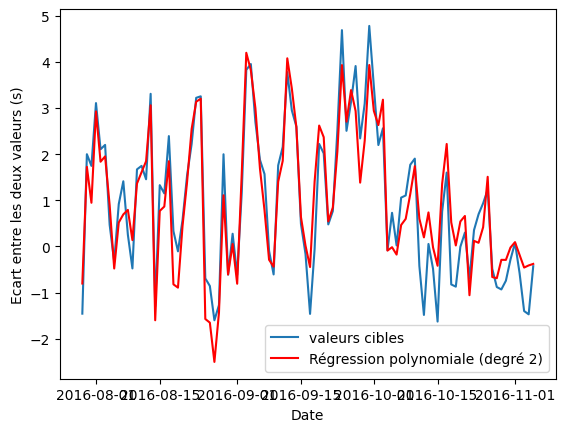

r2 : 0.6789221172498621
rmse : 1.009122328595135


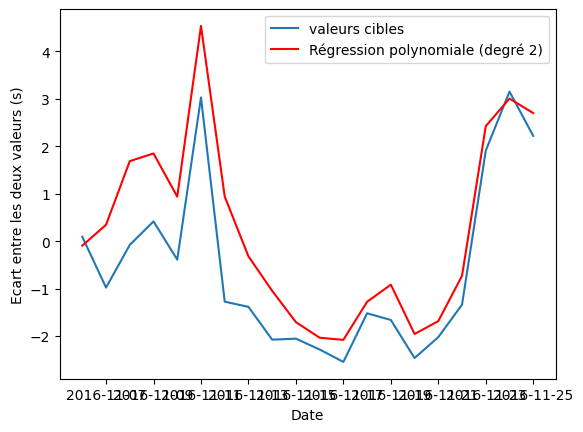

In [132]:
longueur= 100

# Train
X_train = [np.array(data['Hauteur'].iloc[:longueur]),np.array((data['Hauteur']**2).iloc[:longueur]),np.array(data['Période'].iloc[:longueur]),np.array((data['Période']**2).iloc[:longueur])]
Y_train = np.array(data['Période'].iloc[:longueur]-data['mpts'].iloc[:longueur])

X_train=np.transpose(X_train)
X_train=np.c_[X_train,np.ones(X_train.shape[0])]
m=np.linalg.lstsq(X_train,Y_train,rcond=None)[0]

Y_train_poly = 0
for i in range(4):
    Y_train_poly += X_train[:,i]*m[i]
c =[m[4]for k in range(longueur)]

Y_train_poly+=c
# Erreur
print("r2 :", metrics.r2_score(Y_train, Y_train_poly))
print("rmse :", np.sqrt(metrics.mean_squared_error(Y_train, Y_train_poly)))

# Tracer les données et la courbe de régression polynomiale
plt.plot(data['DateTime'].iloc[:longueur],data['Période'].iloc[:longueur]-data['mpts'].iloc[:longueur], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[:longueur], Y_train_poly, 'r-', label='Régression polynomiale (degré 2)')
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (s)')
plt.legend()
plt.show()

# Test
X_test_poly = [np.array(data['Hauteur'].iloc[longueur:120]),np.array((data['Hauteur']**2).iloc[longueur:120]),np.array(data['Période'].iloc[longueur:120]),np.array((data['Période']**2).iloc[longueur:120])]
X_test_poly=np.transpose(X_test_poly)
X_test_poly=np.c_[X_test_poly,np.ones(X_test_poly.shape[0])]

Y_test=0
for i in range(4):
    Y_test += X_test_poly[:,i]*m[i]
c =[m[4]for k in range(120-longueur)]
Y_test+=c

# Erreur
print("r2 :", metrics.r2_score(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test)))

# Tracer les données et la courbe de régression polynomiale
plt.plot(data['DateTime'].iloc[longueur:120],data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], Y_test, 'r-', label='Régression polynomiale (degré 2)')
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (s)')
plt.legend()
plt.show()

Foret aléatoire

r2 : 0.6112890482211553
rmse : 1.1103298333723086


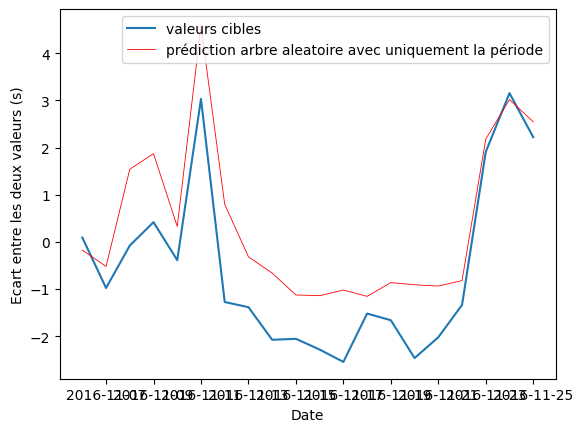

In [133]:
data_rescaled = data.copy()
column_n=['Hauteur','Période']
for column in column_n:
    data_rescaled[column] = (data_rescaled[column] - data_rescaled[column].min()) / (data_rescaled[column].max() - data_rescaled[column].min())

data_gaussienne = data.copy()
for column in column_n:
    transformer = StandardScaler().fit(data_gaussienne[[column]])
    data_gaussienne[column] = transformer.transform(data_gaussienne[[column]])

longueur= 100

# Train
X_train = data_gaussienne[['Hauteur','Période']].iloc[:longueur]
#X_train = data_rescaled[['Période']].iloc[:longueur]
Y_train = data['Période'].iloc[:longueur]-data['mpts'].iloc[:longueur]

#Test
X_test =  data_gaussienne[['Hauteur','Période']].iloc[longueur:120]
#X_test =  data_rescaled[['Période']].iloc[longueur:120]
model = ensemble.RandomForestRegressor(random_state=40)
model.fit(X_train, Y_train)

#Prédiction
Y_test = model.predict(X_test)

# Affichez les résultats
print("r2 :", metrics.r2_score(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test)))

plt.plot(data['DateTime'].iloc[longueur:120],data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], Y_test, color = 'r', linewidth = .6, label = 'prédiction arbre aleatoire avec uniquement la période')
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (s)')
plt.legend()

r2 : 0.7910406469278898
rmse : 0.8140845789823037


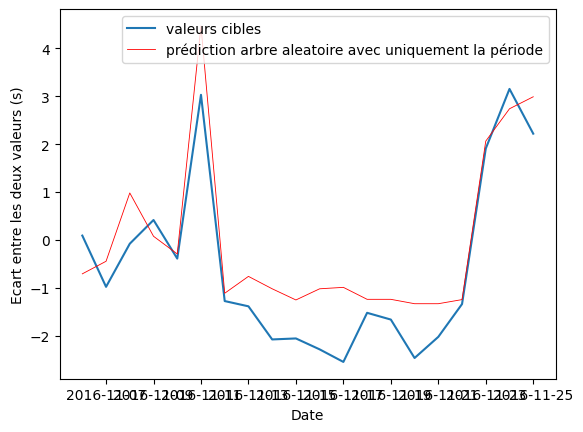

In [134]:
longueur= 100
# Train
X_train = data[['Période']].iloc[:longueur]
Y_train = data['Période'].iloc[:longueur]-data['mpts'].iloc[:longueur]

#Test
X_test =  data[['Période']].iloc[longueur:120]
model = ensemble.RandomForestRegressor(random_state=42,n_estimators=50)
model.fit(X_train, Y_train)

#Prédiction
Y_test = model.predict(X_test)

# Affichez les résultats
print("r2 :", metrics.r2_score(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test)))

plt.plot(data['DateTime'].iloc[longueur:120],data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], Y_test, color = 'r', linewidth = .6, label = 'prédiction arbre aleatoire avec uniquement la période')
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (s)')
plt.legend()
plt.savefig('output/predire erreur/prédiction arbre aleatoire avec uniquement la période')

L'algorithme avec  5  arbres est le plus performant avec un score de 0.7936969375745285


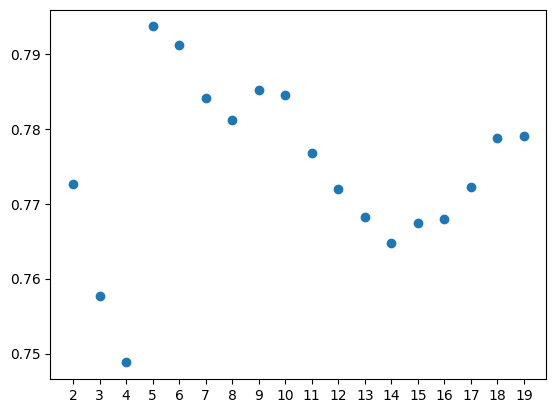

In [135]:
longueur= 100
# Train
X_train = data[['Période']].iloc[:longueur]
Y_train = data['Période'].iloc[:longueur]-data['mpts'].iloc[:longueur]

#Test
X_test =  data[['Période']].iloc[longueur:120]
scores=[]
Nb_arbres=[i for i in range(2,20)]
for n in Nb_arbres:
    model = ensemble.RandomForestRegressor(n_estimators=n,random_state =42)
    model.fit(X_train, Y_train)

    #Prédiction
    Y_test = model.predict(X_test)
    scores.append(metrics.r2_score(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test))
    
plt.xticks(Nb_arbres)
plt.plot(Nb_arbres,scores, linestyle = 'none', marker = 'o')
print("L'algorithme avec ",Nb_arbres[np.argmax(scores)]," arbres est le plus performant avec un score de", scores[np.argmax(scores)])


Text(0, 0.5, 'R2 score')

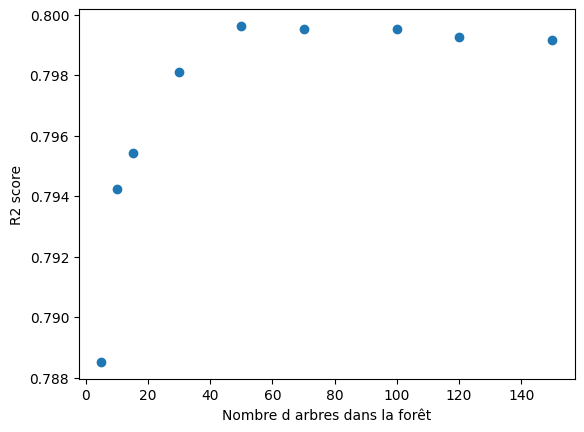

In [136]:
longueur= 100
# Train
X_train = data[['Période']].iloc[:longueur]
Y_train = data['Période'].iloc[:longueur]-data['mpts'].iloc[:longueur]

#Test
X_test =  data[['Période']].iloc[longueur:120]
S_t=[0 for i in range(9)]
for k in range(100):
    scores=[]
    Nb_arbres=[5,10,15,30,50,70,100,120,150]
    for index,n in enumerate(Nb_arbres):

        model = ensemble.RandomForestRegressor(n_estimators=n,random_state =k)
        model.fit(X_train, Y_train)

        #Prédiction
        Y_test = model.predict(X_test)
        scores.append(metrics.r2_score(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test))
        S_t[index]+=(metrics.r2_score(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]),Y_test))
for i in range(9):
    S_t[i]=S_t[i]/100
plt.scatter(Nb_arbres,S_t)
plt.xlabel('Nombre d arbres dans la forêt')
plt.ylabel('R2 score')

r2 : 0.8112420930611665
rmse : 0.7737331371364602


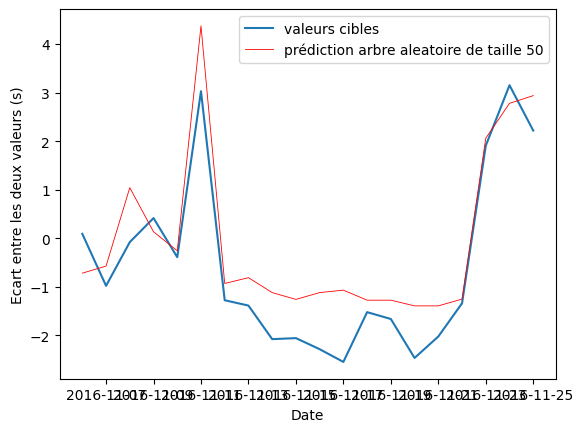

In [137]:
longueur = 100
n = 50
# Train
X_train = data[['Période']].iloc[:longueur]
Y_train = data['Période'].iloc[:longueur]-data['mpts'].iloc[:longueur]

#Test
X_test =  data[['Période']].iloc[longueur:120]
model = ensemble.RandomForestRegressor(n_estimators=n)
model.fit(X_train, Y_train)

#Prédiction
Y_test = model.predict(X_test)

# Affichez les résultats
print("r2 :", metrics.r2_score(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120]), Y_test)))

plt.plot(data['DateTime'].iloc[longueur:120],data['Période'].iloc[longueur:120]-data['mpts'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], Y_test, color = 'r', linewidth = .6, label = 'prédiction arbre aleatoire de taille '+str(n))
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (s)')
plt.legend()

r2 : -0.37579075983303456
rmse : 8.23948493980388


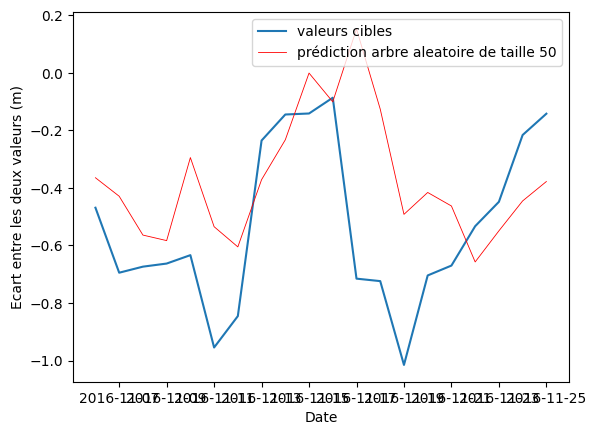

In [138]:
longueur = 100
n = 50
# Train
X_train = data[['Hauteur','Période']].iloc[:longueur]
#X_train = data[['Période']].iloc[:longueur]
Y_train = data['Hauteur'].iloc[:longueur]-data['swh'].iloc[:longueur]

#Test
X_test =  data[['Hauteur','Période']].iloc[longueur:120]
#X_test =  data[['Période']].iloc[longueur:120]
model = ensemble.RandomForestRegressor(n_estimators=n)
model.fit(X_train, Y_train)

#Prédiction
Y_test = model.predict(X_test)

# Affichez les résultats
print("r2 :", metrics.r2_score(np.array(data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120]), Y_test))
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(data['Période'].iloc[longueur:120]-data['swh'].iloc[longueur:120]), Y_test)))

plt.plot(data['DateTime'].iloc[longueur:120],data['Hauteur'].iloc[longueur:120]-data['swh'].iloc[longueur:120], label = 'valeurs cibles')
plt.plot(data['DateTime'].iloc[longueur:120], Y_test, color = 'r', linewidth = .6, label = 'prédiction arbre aleatoire de taille '+str(n))
plt.xlabel('Date')
plt.ylabel('Ecart entre les deux valeurs (m)')
plt.legend()

# Création dataframe

In [139]:
fill_houle = pd.merge(nouv_houle, wave_era5, on='DateTime', how='outer')

fill_houle['swh'] = fill_houle['Hauteur'].fillna(fill_houle['swh'])
fill_houle['mpts'] = fill_houle['Période'].fillna(fill_houle['mpts'])

fill_houle.reset_index(inplace=True)
fill_houle = fill_houle.drop(columns='Hauteur')
fill_houle = fill_houle.drop(columns='Période')
fill_houle = fill_houle.rename(columns={'mpts':'Période'})
fill_houle = fill_houle.rename(columns={'swh':'Hauteur'})

fill_houle = fill_houle.drop(columns='index_x')
fill_houle = fill_houle.drop(columns='index_y')
fill_houle = fill_houle.drop(columns='index')

# Indicateur d'énergie

In [140]:
pw = 997 #kg.m-3
g = 9.806 #m.s-2
fill_houle['puissance'] = (pw*(g**2)*fill_houle['Période']*(fill_houle['Hauteur']**2))/(64*np.pi)

# Comparaison indicateur énergie era 5 et in situ

In [141]:
wave_test_2016 = wave_era5[(wave_era5['DateTime'] >= pd.to_datetime('2016-07-29'))&(wave_era5['DateTime'] <= pd.to_datetime('2016-11-25'))]

C:\Users\julie\AppData\Local\Temp\ipykernel_18444\4070727025.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(5000.0, 60000.0)

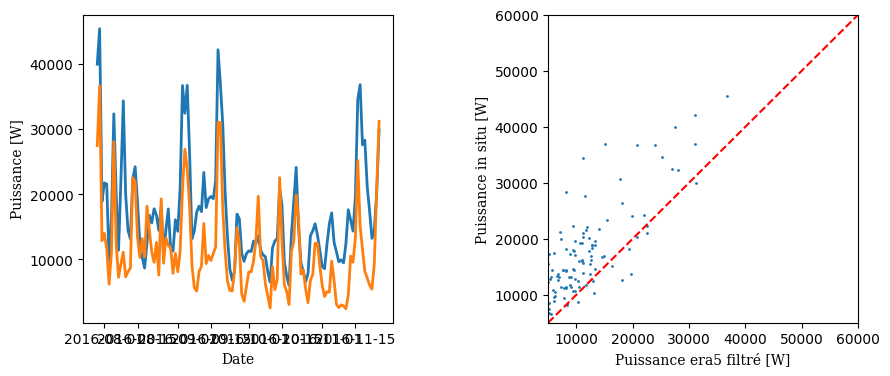

In [142]:
wave_test_2016.loc[:,'Puissance'] = (pw*(g**2)*wave_test_2016['mpts']*(wave_test_2016['swh']**2))/(64*np.pi)

nouv_houle_2016.loc[:,'Puissance'] = (pw*(g**2)*nouv_houle_2016['Période']*(nouv_houle_2016['Hauteur']**2))/(64*np.pi)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

# Premier sous-graphique
axs[0].plot(wave_test_2016['DateTime'], wave_test_2016['Puissance'], label = 'era 5 filtré', linewidth = 2)
axs[0].plot(nouv_houle_2016['DateTime'], nouv_houle_2016['Puissance'], linewidth = 2, label = 'in situ')
axs[0].set_xlabel('Date', fontfamily = 'serif')
axs[0].set_ylabel('Puissance [W]', fontfamily = 'serif')
#plt.savefig('output/Comparaison puissance/Comparaison puissance in situ & era 5')

# Deuxième sous-graphique
axs[1].scatter(nouv_houle_2016['Puissance'], wave_test_2016['Puissance'], s = 1)
axs[1].plot(np.linspace(5000, 60000, 1000), np.linspace(5000, 60000, 1000), color = 'r', linestyle = '--')
axs[1].plot(np.linspace(28, 30, 10), np.linspace(28, 30, 10), color = 'r', linestyle = '--')
axs[1].set_xlabel('Puissance era5 filtré [W]', fontfamily = 'serif')
axs[1].set_ylabel('Puissance in situ [W]', fontfamily = 'serif')
axs[1].set_ylim(5000, 60000)
axs[1].set_xlim(5000, 60000)



In [143]:
print("rmse :", np.sqrt(metrics.mean_squared_error(nouv_houle_2016['Puissance'], wave_test_2016['Puissance'])))

rmse : 7576.116285636049


Text(0.5, 1.0, 'Incertitude Puissance')

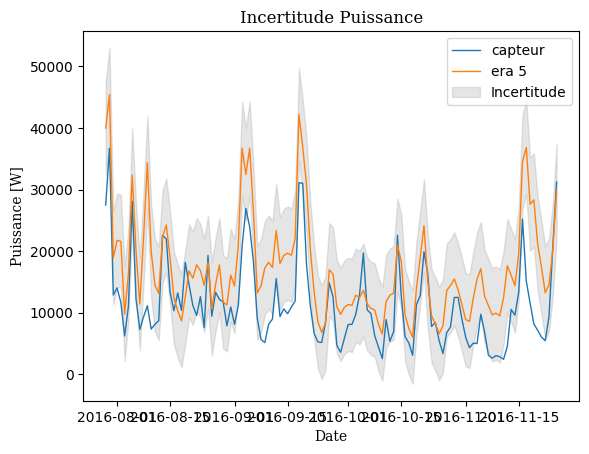

In [144]:
ecart = np.sqrt(metrics.mean_squared_error(nouv_houle_2016['Puissance'], wave_test_2016['Puissance']))
plt.plot(nouv_houle_2016['DateTime'], nouv_houle_2016['Puissance'], label = 'capteur', linewidth = 1)
plt.plot(wave_test_2016['DateTime'], wave_test_2016['Puissance'], linewidth = 1, label = 'era 5')
plt.fill_between(wave_test_2016['DateTime'], wave_test_2016['Puissance'] - ecart, wave_test_2016['Puissance'] + ecart, color='gray', alpha=0.2, label='Incertitude')
plt.legend()
plt.xlabel('Date', fontfamily = 'serif')
plt.ylabel('Puissance [W]', fontfamily = 'serif')
plt.title('Incertitude Puissance', fontfamily = 'serif')
#plt.savefig('output/Comparaison puissance/Incertitudes')

# Transformée de Fourier

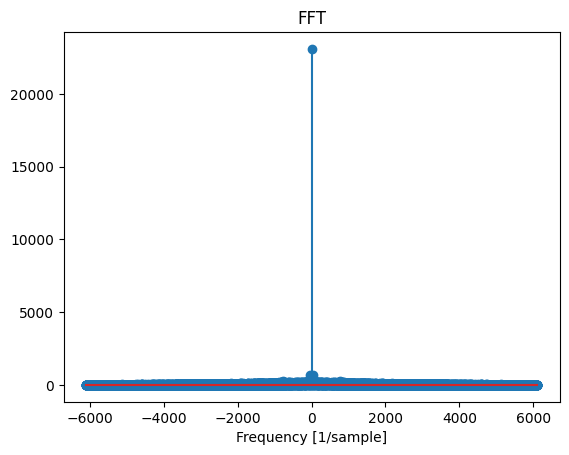

In [145]:
def fourier_transform(fo, inverse=False):
    N = fo.shape[0]
    n = np.arange(N)
    k = np.arange(N)
    k_n = k.reshape((N,1)).dot(n.reshape((1,N)))
    if inverse : 
        sign = 1
        fact = 1/N
    else :
        sign = -1
        fact = 1
    exp_i_n_omega_k = np.exp(sign*2j*np.pi*k_n/N)
    f_n= fo.reshape((N,1))

    f_hat = fact*exp_i_n_omega_k.dot(f_n)
    f_hat = f_hat.reshape(fo.shape)
    return f_hat

hauteur_fourier=fill_houle['Hauteur']
hauteur_fourier=hauteur_fourier.to_numpy()


fhat = fourier_transform(hauteur_fourier)
fcheck = np.fft.fft(hauteur_fourier)


freqs = np.arange(fhat.size//2)
freqs = np.concatenate((freqs, -freqs[::-1]))


plt.stem(freqs, np.abs(fcheck))
plt.title('FFT')
plt.xlabel('Frequency [1/sample]')
plt.show()

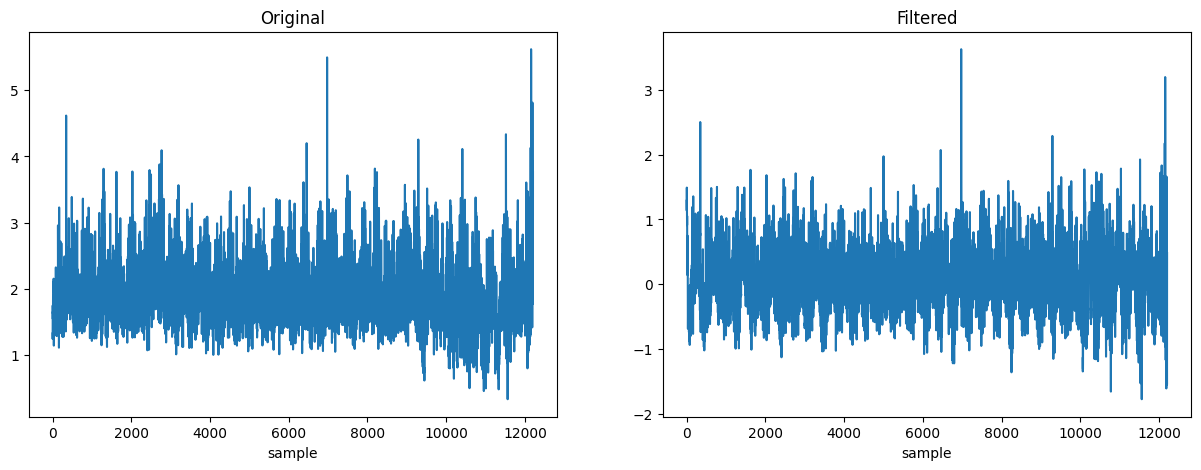

Reconstruction error: 212.57693295044598
215.26420929730799


In [146]:
sos = signal.butter(10, 2.7*10**(-3), 'highpass', output='sos')
#sos = signal.butter(10,[2.7*10**(-3),5.4*10**(-3)], 'bandstop', output='sos')
filtered_h = signal.sosfilt(sos, hauteur_fourier)
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(hauteur_fourier)
plt.title('Original')
plt.xlabel('sample')
plt.subplot(1, 2, 2)
plt.plot(filtered_h)
plt.title('Filtered')
plt.xlabel('sample')
plt.show()
print('Reconstruction error: ' + str(np.linalg.norm(hauteur_fourier - filtered_h)))
print(np.linalg.norm(hauteur_fourier))

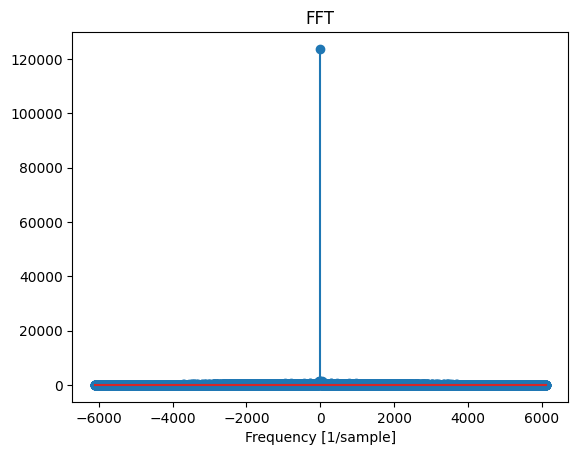

In [147]:
période_fourier=fill_houle['Période']
période_fourier=période_fourier.to_numpy()

# Direct Fourier transform
fhat = fourier_transform(période_fourier)
fcheck = np.fft.fft(période_fourier)

# Frequency shift
freqs = np.arange(fhat.size//2)
freqs = np.concatenate((freqs, -freqs[::-1]))

# Display
plt.stem(freqs, np.abs(fcheck))
plt.title('FFT')
plt.xlabel('Frequency [1/sample]')
plt.show()

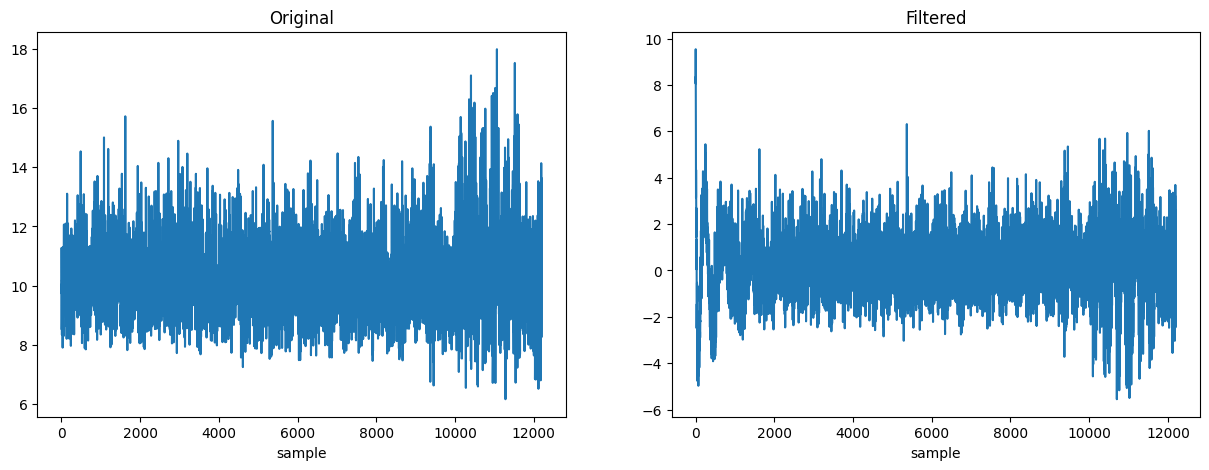

Reconstruction error: 1125.40529750765
1128.7910408025352


In [148]:
sos = signal.butter(10, 2.7*10**(-3), 'highpass', output='sos')
#sos = signal.butter(10,[2.7*10**(-3),5.4*10**(-3)], 'bandstop', output='sos')
filtered_p = signal.sosfilt(sos, période_fourier)
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(période_fourier)
plt.title('Original')
plt.xlabel('sample')
plt.subplot(1, 2, 2)
plt.plot(filtered_p)
plt.title('Filtered')
plt.xlabel('sample')
plt.show()
print('Reconstruction error: ' + str(np.linalg.norm(période_fourier - filtered_p)))
print(np.linalg.norm(période_fourier))

In [149]:
fill_houle=fill_houle
fill_houle['Hauteur f']=filtered_h
fill_houle['Période f']=filtered_p
fill_houle['puissance f']=(pw*(g**2)*fill_houle['Période f']*(fill_houle['Hauteur f']**2))/(64*np.pi)

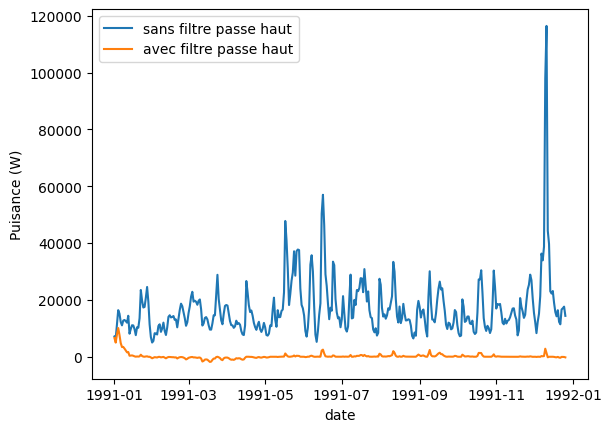

In [150]:
plt.plot(fill_houle['DateTime'][:360],fill_houle['puissance'][:360], label='sans filtre passe haut')
plt.plot(fill_houle['DateTime'][:360],fill_houle['puissance f'][:360], label='avec filtre passe haut')
plt.legend()
plt.ylabel('Puisance (W)')
plt.xlabel('date')
plt.savefig('output/Fourier/variation puissance avec et sans fourier')

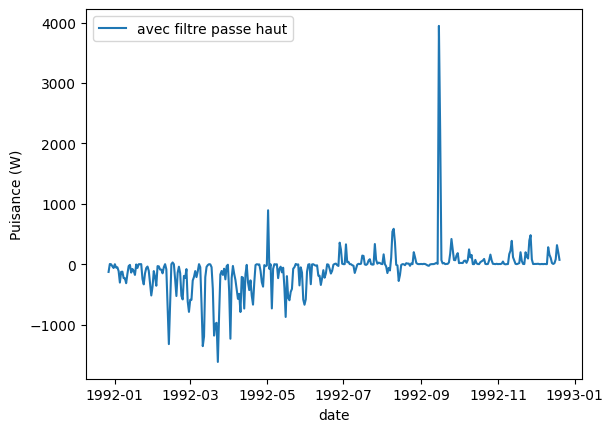

In [151]:
plt.plot(fill_houle['DateTime'][360:720],fill_houle['puissance f'][360:720], label='avec filtre passe haut')
plt.legend()
plt.ylabel('Puisance (W)')
plt.xlabel('date')
plt.savefig('output/Fourier/variation puissance avec fourier')

# Autre moyen d enlever la saisonnalité avec STL

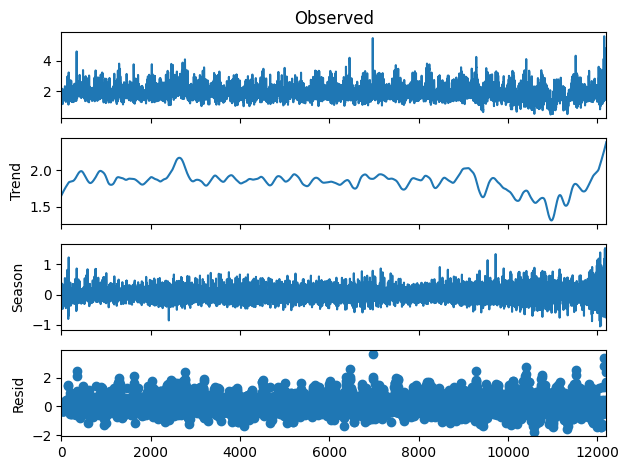

In [152]:
hauteur = fill_houle[['Hauteur','DateTime']]
hauteur = hauteur.resample('D',on='DateTime').mean().ffill()
hauteur.index = [i for i in range(hauteur.shape[0])]

res_hauteur = STL(hauteur, period=180,robust=True).fit()
res_hauteur.plot()
plt.show()

In [153]:
fill_houle['Hauteur STL']=fill_houle['Hauteur']-res_hauteur.seasonal # on retire la composante saisonnière

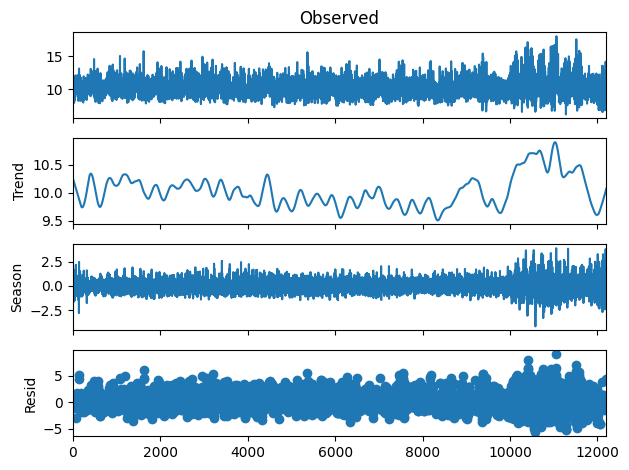

In [154]:
periode = fill_houle[['Période','DateTime']]
periode = periode.resample('D',on='DateTime').mean().ffill()
periode.index = [i for i in range(periode.shape[0])]

res_periode = STL(periode, period=180,robust=True).fit()
res_periode.plot()
plt.show()

In [155]:
fill_houle['Période STL']=fill_houle['Période']-res_periode.seasonal # on retire la composante saisonnière

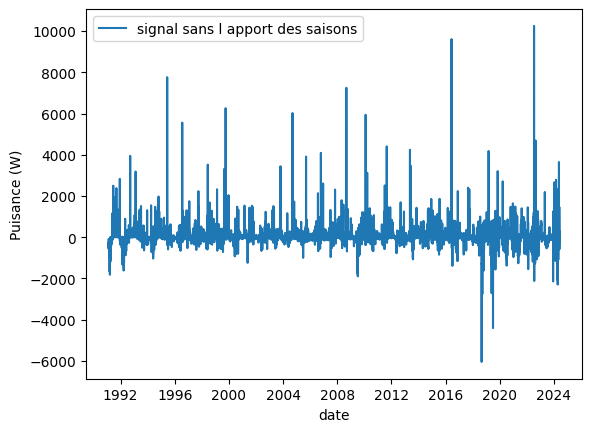

In [156]:
fill_houle['puissance STL']=(pw*(g**2)*fill_houle['Période STL']*(fill_houle['Hauteur STL']**2))/(64*np.pi)
plt.plot(fill_houle['DateTime'][40:],fill_houle['puissance f'][40:], label='signal sans l apport des saisons')
plt.legend()
plt.ylabel('Puisance (W)')
plt.xlabel('date')
plt.savefig('output/Fourier/variation puissance avec decomposition')

# Exporter

In [157]:
fill_houle.to_csv('Tableaux finaux variables/fill_houle.csv', index = False)